# Initial Setup

In [1]:
# Load Virtual Environment

!& "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Scripts\Activate.ps1"


& was unexpected at this time.


In [2]:
# --- Core ---
import os
import sys
import re
import glob
import time
import unicodedata
import importlib
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Dates & holidays ---
import holidays

# --- Statsmodels ---
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Scikit-learn: preprocessing & pipelines ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PolynomialFeatures,
    OrdinalEncoder,
)
from sklearn.pipeline import Pipeline
import category_encoders as ce
from category_encoders import TargetEncoder

# --- Scikit-learn: models ---
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet,
    LogisticRegression,
)
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

# --- Scikit-learn: model selection & metrics ---
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)

# --- Feature selection ---
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# --- Distributions ---
from scipy.stats import loguniform, randint, uniform

# --- Utilities ---
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from joblib import parallel_backend

# --- Gradient boosting libraries ---
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --- Hyperparameter optimization ---
import optuna

In [27]:
# # To reload custom modules
importlib.reload(sys.modules['utils'])
importlib.reload(sys.modules['experiment'])

<module 'experiment' from 'C:\\Users\\tbran\\Python\\repos\\Semester 3 Repos\\capstone\\src\\experiment.py'>

In [3]:
project_path = Path("C:/Users/tbran/Python/repos/Semester 3 Repos/capstone/")
data_path    = project_path / "data"
src_path     = project_path / "src"
model_path   = project_path / "models"
logs_path    = project_path / "logs"

mend_log_file     = logs_path / "mend_results_v3.csv"
usdot_log_file    = logs_path / "usdot_results_v3.csv"
mend_cv_log_file     = logs_path / "mend_cv_results_v3.csv"
usdot_cv_log_file    = logs_path / "usdot_cv_results_v3.csv"

# Make sure Python can see your src/ folder
sys.path.append(str(src_path))

# Initialize results list
mend_results = []
usdot_results = []

random_state = 42

from utils import log_results_to_csv
from experiment import run_experiment

# Data Prep

## Shared Data Prep Functions

In [4]:
def optimize_dataframe(df, datetime_cols=None, fillna=False):
    """
    Cleans and optimizes a DataFrame:
    - Converts object datetime columns to datetime64
    - Converts object columns with repeated values to category
    - Downcasts numeric columns to smallest safe type
    - Optionally fills NaNs before downcasting
    
    Parameters:
        df (pd.DataFrame): The DataFrame to optimize
        datetime_cols (list): List of column names to convert to datetime
        fillna (bool): If True, fills NaNs before downcasting
    """
    
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage before optimization: {start_mem:.2f} MB")
    
    df = df.copy()
    
    # 1. Convert datetime columns
    if datetime_cols:
        for col in datetime_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # 2. Convert object columns to category if appropriate
    obj_cols = df.select_dtypes(include=['object']).columns
    for col in obj_cols:
        num_unique = df[col].nunique()
        num_total = len(df[col])
        if num_unique / num_total < 0.5:  # heuristic: less than 50% unique
            df[col] = df[col].astype('category')
    
    # 3. Downcast numeric columns
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns
    
    for col in int_cols:
        if fillna and df[col].isnull().any():
            df[col] = df[col].fillna(0)
        df[col] = pd.to_numeric(df[col], downcast='integer')
    
    for col in float_cols:
        if fillna and df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mean())
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    print(f"Reduced by {100 * (start_mem - end_mem) / start_mem:.1f}%")
    
    return df


def clean_column_names(df, remove_accents=True):
    """
    Cleans DataFrame column names:
    - Strips whitespace
    - Converts to lowercase
    - Replaces spaces & special chars with underscores
    - Removes duplicate underscores
    - Optionally removes accents
    
    Parameters:
        df (pd.DataFrame): DataFrame whose columns to clean
        remove_accents (bool): If True, strips accents from characters
    
    Returns:
        pd.DataFrame: DataFrame with cleaned column names
    """
    def _clean(col):
        col = col.strip().lower()
        if remove_accents:
            col = ''.join(
                c for c in unicodedata.normalize('NFKD', col)
                if not unicodedata.combining(c)
            )
        col = re.sub(r'[^0-9a-zA-Z]+', '_', col)  # replace non-alphanumeric with _
        col = re.sub(r'_+', '_', col)             # collapse multiple underscores
        col = col.strip('_')                      # remove leading/trailing underscores
        return col
    
    df = df.copy()
    df.columns = [_clean(c) for c in df.columns]
    return df


def build_preprocessing_pipeline(df, target, 
                                  high_card_threshold=20, 
                                  scale_numeric=False):
    """
    Builds a preprocessing pipeline for linear regression:
    - One-hot encodes low-cardinality categorical columns
    - Target encodes high-cardinality categorical columns
    - Optionally scales numeric columns
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (including target column)
        target (str): Name of target column
        high_card_threshold (int): Unique value cutoff for high-cardinality
        scale_numeric (bool): Whether to scale numeric features
        
    Returns:
        pipeline (ColumnTransformer): Preprocessing transformer
        low_card_cols (list): Low-cardinality categorical columns
        high_card_cols (list): High-cardinality categorical columns
        num_cols (list): Numeric columns
    """
    
    # Separate features and target
    X = df.drop(columns=[target])
    
    # Identify column types
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    # Split categorical into low/high cardinality
    low_card_cols = [col for col in cat_cols if X[col].nunique() <= high_card_threshold]
    high_card_cols = [col for col in cat_cols if X[col].nunique() > high_card_threshold]
    
    # Transformers
    low_card_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    high_card_transformer = TargetEncoder()
    num_transformer = StandardScaler() if scale_numeric else 'passthrough'
    
    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_card', low_card_transformer, low_card_cols),
            ('high_card', high_card_transformer, high_card_cols),
            ('num', num_transformer, num_cols)
        ]
    )
    
    return preprocessor, low_card_cols, high_card_cols, num_cols

def add_interaction_terms(df, features):
    """
    Adds pairwise interaction terms between given features.
    """
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_array = poly.fit_transform(df[features])
    interaction_df = pd.DataFrame(interaction_array, columns=poly.get_feature_names_out(features))
    return pd.concat([df.reset_index(drop=True), interaction_df], axis=1)

def preprocess_features(df, categorical_cols, numeric_cols):
    """
    Returns a ColumnTransformer that one-hot encodes categorical columns
    and passes numeric columns through unchanged.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
            ('num', 'passthrough', numeric_cols)
        ]
    )
    return preprocessor

def transform_with_names(preprocessor, X, y=None):
    """Fit/transform and return a DataFrame with feature names preserved."""
    Xt = preprocessor.fit_transform(X, y)
    cols = preprocessor.get_feature_names_out()
    return pd.DataFrame(Xt, columns=cols, index=X.index)


def create_features_mend(df):
    df = df.copy()

    # Build U.S. holiday calendar for relevant years
    us_holidays = holidays.US(years=range(2015, 2027))

    # Build a list of (holiday_date, holiday_name)
    holiday_items = list(us_holidays.items())

    # Create a set of all holiday dates ±3 days
    holiday_buffer = {}
    for h_date, h_name in holiday_items:
        for offset in range(-3, 4):  # -3, -2, -1, 0, +1, +2, +3
            holiday_buffer[h_date + pd.Timedelta(days=offset)] = h_name

    # Binary flag: within ±3 days of a holiday
    if "scheduleddepartdatetime" in df.columns:
        print("Adding holiday features...")
        df['is_holiday_period'] = df['scheduleddepartdatetime'].dt.date.isin(holiday_buffer.keys())

        # Categorical holiday name (or "None")
        def get_holiday_name(d):
            return holiday_buffer.get(d, "None")

        df['holiday_name'] = df['scheduleddepartdatetime'].dt.date.apply(get_holiday_name)
    else:
        print("Column 'scheduleddepartdatetime' not found, skipping holiday features.")

    # --- Existing engineered features ---
    if "scheduleddepartdatetime" in df.columns:
        print("Adding time-based features...")
        df["dayofweek"] = df["scheduleddepartdatetime"].dt.dayofweek
        df["month"] = df["scheduleddepartdatetime"].dt.month
    else:
        print("Skipping time-based features.")

    if {"origin","dest"}.issubset(df.columns):
        print("Adding route feature...")
        df["route"] = df["origin"].astype(str) + "_" + df["dest"].astype(str)
    else:
        print("Skipping route feature.")

    if {"marketshareorigin","marketsharedest"}.issubset(df.columns):
        print("Adding marketshare_diff...")
        df["marketshare_diff"] = df["marketshareorigin"] - df["marketsharedest"]
    else:
        print("Skipping marketshare_diff.")

    if {"hhiorigin","hhidest"}.issubset(df.columns):
        print("Adding hhi_diff...")
        df["hhi_diff"] = df["hhiorigin"] - df["hhidest"]
    else:
        print("Skipping hhi_diff.")

    if {"temperature","windspeed"}.issubset(df.columns):
        print("Adding temp_wind_interaction...")
        df["temp_wind_interaction"] = df["temperature"] * df["windspeed"]
    else:
        print("Skipping temp_wind_interaction.")

    if {"temperature","windgustspeed"}.issubset(df.columns):
        print("Adding temp_windgust_interaction...")
        df["temp_windgust_interaction"] = df["temperature"] * df["windgustspeed"]
    else:
        print("Skipping temp_windgust_interaction.")

    if {"windspeed","windgustspeed"}.issubset(df.columns):
        print("Adding wind_gust_diff...")
        df["wind_gust_diff"] = df["windspeed"] - df["windgustspeed"]
    else:
        print("Skipping wind_gust_diff.")

    if {"raindummy","windspeed"}.issubset(df.columns):
        print("Adding rain_wind_interaction...")
        df["rain_wind_interaction"] = df["raindummy"] * df["windspeed"]
    else:
        print("Skipping rain_wind_interaction.")

    if {"snowdummy","windspeed"}.issubset(df.columns):
        print("Adding snow_wind_interaction...")
        df["snow_wind_interaction"] = df["snowdummy"] * df["windspeed"]
    else:
        print("Skipping snow_wind_interaction.")

    if {"raindummy","windgustspeed"}.issubset(df.columns):
        print("Adding rain_wind_gust_interaction...")
        df["rain_wind_gust_interaction"] = df["raindummy"] * df["windgustspeed"]
    else:
        print("Skipping rain_wind_gust_interaction.")

    if {"snowdummy","windgustspeed"}.issubset(df.columns):
        print("Adding snow_wind_gust_interaction...")
        df["snow_wind_gust_interaction"] = df["snowdummy"] * df["windgustspeed"]
    else:
        print("Skipping snow_wind_gust_interaction.")

    if {"originmetropop","destmetropop"}.issubset(df.columns):
        print("Adding metropop_diff...")
        df["metropop_diff"] = df["originmetropop"] - df["destmetropop"]
    else:
        print("Skipping metropop_diff.")

    if {"originmetrogdppercapita","destmetrogdppercapita"}.issubset(df.columns):
        print("Adding metrogdp_diff...")
        df["metrogdp_diff"] = df["originmetrogdppercapita"] - df["destmetrogdppercapita"]
    else:
        print("Skipping metrogdp_diff.")

    return df

def engineer_flight_features_light(
    df,
    datetime_col="scheduleddepartdatetime",
    origin_col="origin",
    dest_col="dest",
    carrier_col="uniquecarrier",
    delay_col="depdelay",
    distance_col="distance"
):
    df = df.copy()

    # --- Datetime parts ---
    dt = pd.to_datetime(df[datetime_col])
    df["year"] = dt.dt.year
    df["month"] = dt.dt.month
    df["day"] = dt.dt.day
    df["hour"] = dt.dt.hour
    df["date"] = dt.dt.floor("D")
    df["is_weekend"] = dt.dt.dayofweek >= 5

    # --- Route & distance ---
    df["route"] = df[origin_col].astype(str) + "_" + df[dest_col].astype(str)
    if distance_col in df.columns:
        df["distance_bin"] = pd.cut(
            df[distance_col],
            bins=[0, 500, 1500, 3000, 10000],
            labels=["short", "medium", "long", "ultra"]
        )

    # --- Congestion (lighter via merge instead of transform) ---
    # Hourly origin flights
    hourly_counts = (
        df.groupby([origin_col, "date", "hour"], observed=True)
          .size()
          .reset_index(name="hourly_origin_flights")
    )
    df = df.merge(hourly_counts, on=[origin_col, "date", "hour"], how="left")

    # Daily route flights
    daily_counts = (
        df.groupby([origin_col, dest_col, "date"], observed=True)
          .size()
          .reset_index(name="daily_route_flights")
    )
    df = df.merge(daily_counts, on=[origin_col, dest_col, "date"], how="left")

    # --- Weather (light) ---
    if "temperature" in df.columns:
        df["is_extreme_temp"] = (df["temperature"] < 0) | (df["temperature"] > 35)
    if {"raindummy", "snowdummy", "windgustdummy"}.issubset(df.columns):
        df["stormy"] = (df["raindummy"] | df["snowdummy"] | df["windgustdummy"]).astype(int)

    # --- Market/demand ---
    if {"capacity", "numflights"}.issubset(df.columns):
        df["capacity_utilization"] = df["numflights"] / df["capacity"].replace(0, np.nan)

    return df


def engineer_flight_features_heavy(
    df,
    datetime_col="scheduleddepartdatetime",
    origin_col="origin",
    dest_col="dest",
    carrier_col="uniquecarrier",
    delay_col="depdelay",
    distance_col="distance",
    window=7
):
    """
    Engineer advanced features for flight delay prediction.
    Optimized for speed, with print statements and timing checkpoints.
    """

    start_time = time.time()
    df = df.copy()
    print("Starting feature engineering...")

    # --- Precompute datetime parts once ---
    t0 = time.time()
    if datetime_col in df.columns:
        dt = pd.to_datetime(df[datetime_col])
        df["year"] = dt.dt.year
        df["month"] = dt.dt.month
        df["day"] = dt.dt.day
        df["hour"] = dt.dt.hour
        df["date"] = dt.dt.floor("D")
        df["quarter"] = dt.dt.quarter
        df["is_weekend"] = dt.dt.dayofweek >= 5
        df["part_of_day"] = pd.cut(
            df["hour"],
            bins=[0,5,11,16,21,24],
            labels=["late_night","morning","midday","evening","night"],
            right=False
        )
        df["days_since_year_start"] = (
            dt - pd.to_datetime(df["year"].astype(str) + "-01-01")
        ).dt.days
    print(f"Datetime features done in {time.time()-t0:.2f}s")

    # --- Route & distance features ---
    t0 = time.time()
    if {origin_col, dest_col}.issubset(df.columns):
        if f"largehubairport{origin_col}" in df.columns and f"largehubairport{dest_col}" in df.columns:
            df["hub_to_hub"] = (
                (df[f"largehubairport{origin_col}"] == 1) &
                (df[f"largehubairport{dest_col}"] == 1)
            ).astype(int)
        df["route"] = df[origin_col].astype(str) + "_" + df[dest_col].astype(str)

    if distance_col in df.columns:
        df["distance_bin"] = pd.cut(
            df[distance_col],
            bins=[0,500,1500,3000,10000],
            labels=["short","medium","long","ultra"]
        )
    print(f"Route & distance features done in {time.time()-t0:.2f}s")

    # --- Congestion features ---
    t0 = time.time()
    if {"date","hour",origin_col}.issubset(df.columns):
        hourly_counts = (
            df.groupby([origin_col,"date","hour"])
              .size()
              .rename("hourly_origin_flights")
              .reset_index()
        )
        df = df.merge(hourly_counts, on=[origin_col,"date","hour"], how="left")

    if {"date",origin_col,dest_col}.issubset(df.columns):
        daily_counts = (
            df.groupby([origin_col,dest_col,"date"])
              .size()
              .rename("daily_route_flights")
              .reset_index()
        )
        df = df.merge(daily_counts, on=[origin_col,dest_col,"date"], how="left")
    print(f"Congestion features done in {time.time()-t0:.2f}s")

    # --- Weather features ---
    t0 = time.time()
    if "temperature" in df.columns:
        df["is_extreme_temp"] = (df["temperature"] < 0) | (df["temperature"] > 35)
        if "month" in df.columns:
            monthly_means = df.groupby("month")["temperature"].transform("mean")
            df["temp_anomaly"] = df["temperature"] - monthly_means

    if {"raindummy","snowdummy","windgustdummy"}.issubset(df.columns):
        df["stormy"] = (
            (df["raindummy"]==1) | (df["snowdummy"]==1) | (df["windgustdummy"]==1)
        ).astype(int)
    print(f"Weather features done in {time.time()-t0:.2f}s")

    # --- Rolling averages ---
    t0 = time.time()
    if {origin_col, delay_col}.issubset(df.columns):
        df = df.sort_values([origin_col, datetime_col])
        df["rolling_origin_delay"] = (
            df.groupby(origin_col)[delay_col]
              .rolling(window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )

    if {dest_col, delay_col}.issubset(df.columns):
        df = df.sort_values([dest_col, datetime_col])
        df["rolling_dest_delay"] = (
            df.groupby(dest_col)[delay_col]
              .rolling(window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )

    if {carrier_col, delay_col}.issubset(df.columns):
        df = df.sort_values([carrier_col, datetime_col])
        df["rolling_carrier_delay"] = (
            df.groupby(carrier_col)[delay_col]
              .rolling(window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )

    if {"route", delay_col}.issubset(df.columns):
        df = df.sort_values(["route", datetime_col])
        df["rolling_route_delay"] = (
            df.groupby("route")[delay_col]
              .rolling(window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )
    print(f"Rolling averages done in {time.time()-t0:.2f}s")

    # --- Market/demand features ---
    t0 = time.time()
    if {"capacity","numflights"}.issubset(df.columns):
        df["capacity_utilization"] = (
            df["numflights"] / df["capacity"].replace(0, np.nan)
        )

    if {origin_col, dest_col, carrier_col}.issubset(df.columns):
        df["route_carrier_count"] = (
            df.groupby([origin_col,dest_col])[carrier_col].transform("nunique")
        )
    print(f"Market/demand features done in {time.time()-t0:.2f}s")

    # --- Interaction features ---
    t0 = time.time()
    if {"is_holiday_period","monopolyroute"}.issubset(df.columns):
        df["holiday_monopoly"] = (
            df["is_holiday_period"].astype(int) * df["monopolyroute"].astype(int)
        )

    if {"is_extreme_temp","hourly_origin_flights"}.issubset(df.columns):
        df["extreme_temp_congestion"] = (
            df["is_extreme_temp"].astype(int) * df["hourly_origin_flights"]
        )
    print(f"Interaction features done in {time.time()-t0:.2f}s")

    print(f"Total feature engineering time: {time.time()-start_time:.2f}s")
    return df


# Define encoders at module scope (picklable)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.int8)
te = TargetEncoder()
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

def build_dual_preprocessors(df, target, feature_cols,
                             high_card_threshold=20, scale_numeric=False):
    """
    Build regression + tree preprocessors using an explicit feature list.
    Returns (regression_preprocessor, tree_preprocessor, X, y).
    """
    X = df[feature_cols].copy()
    y = df[target]

    # Identify column types
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()

    # Split categorical into low/high cardinality
    low_card_cols = [c for c in cat_cols if X[c].nunique() <= high_card_threshold]
    high_card_cols = [c for c in cat_cols if X[c].nunique() > high_card_threshold]

    # Regression preprocessor: OHE + TargetEncoder + scaling
    regression_preprocessor = ColumnTransformer(
        transformers=[
            ("low_card", ohe, low_card_cols),
            ("high_card", te, high_card_cols),
            ("num", StandardScaler() if scale_numeric else "passthrough", num_cols),
        ]
    )

    # Tree preprocessor: Ordinal encode categoricals, passthrough numerics
    tree_preprocessor = ColumnTransformer(
        transformers=[
            ("cat", ord_enc, cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    return regression_preprocessor, tree_preprocessor, X, y


## Data Prep Steps: Mendeley

### Full Refresh

In [5]:
# Load Mendeley Delay Data
file_name = 'MendeleyDelayData.csv'
df_mend = pd.read_csv(data_path / file_name)

df_mend = optimize_dataframe(
    df_mend,
    datetime_cols=['scheduleddepartdatetime'],
    fillna=True
)
df_mend = clean_column_names(df_mend)

file_name = "FAA_AC_REGISTRATION_2021.csv"
df_reg = pd.read_csv(data_path / file_name)

# Left join on stripped tail_num
df_mend_clean_reg = df_mend.merge(
    df_reg,
    how="left",
    left_on=df_mend["tailnum"].str.lstrip("N"),
    right_on="N-NUMBER"
)

# Impute missing values with mode per column
mode_dict = {col: df_reg[col].mode()[0] for col in df_reg.columns if col != "N-NUMBER"}
df_mend_clean_reg = df_mend_clean_reg.fillna(mode_dict)

# Drop duplicate join key
df_mend_clean_reg = df_mend_clean_reg.drop(columns=["N-NUMBER"])
df_mend_clean_reg = clean_column_names(df_mend_clean_reg)

# Remove outliers from dataframe
df_mend_clean = df_mend_clean_reg[df_mend_clean_reg['depdelay'] >= -30]

# Create engineered features
df_mend_clean = create_features_mend(df_mend_clean)
df_mend_clean = engineer_flight_features_light(df_mend_clean)

# Get list of columns
df_mend_id_cols = ['originairportid', 'destairportid', ]
df_mend_cat_cols = ['origin', 'dest', 'uniquecarrier', 'tailnum', 'origincityname', 'originstate', ]
df_mend_date_cols = ['scheduleddepartdatetime', ]
df_mend_target_cols = ['depdelay','arrdelay',]
df_mend_feature_cols = [col for col in df_mend_clean.columns if col not in df_mend_id_cols + df_mend_cat_cols + df_mend_date_cols + df_mend_target_cols]

# # drop leakage columns, ID columns, and date columns
df_mend_clean = df_mend_clean.drop(columns=['arrdelay'] + df_mend_id_cols + df_mend_date_cols).copy()

# Export df to csv
df_mend_clean.to_csv(data_path / 'MendeleyDelayData_Cleaned.csv', index=False)

reg_prep_mend, tree_prep_mend, X_mend, y_mend_numeric = build_dual_preprocessors(df_mend_clean, 
                                                                                 target='depdelay', 
                                                                                 feature_cols=df_mend_feature_cols, 
                                                                                 high_card_threshold=30, scale_numeric=True)

# Create binary target for classification (15 min delay threshold)
y_mend_binary_15 = (y_mend_numeric >= 15).astype(int)

# Ensure categorical columns are string type (Some reg data has mixed types)
cat_cols = ['type_acft', 'ac_weight', 'holiday_name', 'distance_bin']
high_card_cols = ['mfr', 'model', 'route']

for col in cat_cols + high_card_cols:
    X_mend[col] = X_mend[col].astype(str)

# Create seperate transformed datasets for regression and tree models
X_reg_mend = transform_with_names(reg_prep_mend, X_mend, y_mend_numeric)
X_tree_mend = transform_with_names(tree_prep_mend, X_mend, y_mend_numeric)


Memory usage before optimization: 1008.24 MB
Memory usage after optimization: 150.66 MB
Reduced by 85.1%


C:\Users\tbran\AppData\Local\Temp\ipykernel_7048\1527825268.py:13: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reg = pd.read_csv(data_path / file_name)


Adding holiday features...
Adding time-based features...
Adding route feature...
Adding marketshare_diff...
Adding hhi_diff...
Adding temp_wind_interaction...
Adding temp_windgust_interaction...
Adding wind_gust_diff...
Adding rain_wind_interaction...
Adding snow_wind_interaction...
Adding rain_wind_gust_interaction...
Adding snow_wind_gust_interaction...
Adding metropop_diff...
Adding metrogdp_diff...


### Refresh from cleaned CSV

In [ ]:
df_mend_clean = pd.read_csv(data_path / 'MendeleyDelayData_Cleaned.csv')

# Get list of columns
df_mend_id_cols = ['originairportid', 'destairportid', ]
df_mend_cat_cols = ['origin', 'dest', 'uniquecarrier', 'tailnum', 'origincityname', 'originstate', ]
df_mend_date_cols = ['scheduleddepartdatetime', ]
df_mend_target_cols = ['depdelay','arrdelay',]
df_mend_feature_cols = [col for col in df_mend_clean.columns if col not in df_mend_id_cols + df_mend_cat_cols + df_mend_date_cols + df_mend_target_cols]

# drop leakage columns, ID columns, and date columns
df_mend_clean = df_mend_clean.drop(columns=['arrdelay'] + df_mend_id_cols + df_mend_date_cols).copy()

reg_prep_mend, tree_prep_mend, X_mend, y_mend_numeric = build_dual_preprocessors(df_mend_clean, 
                                                                                 target='depdelay', 
                                                                                 feature_cols=df_mend_feature_cols, 
                                                                                 high_card_threshold=30, scale_numeric=True)

# Create binary target for classification (15 min delay threshold)
y_mend_binary_15 = (y_mend_numeric >= 15).astype(int)

# Ensure categorical columns are string type (Some reg data has mixed types)
cat_cols = ['type_acft', 'ac_weight', 'holiday_name', 'distance_bin']
high_card_cols = ['mfr', 'model', 'route']

for col in cat_cols + high_card_cols:
    X_mend[col] = X_mend[col].astype(str)

# Create seperate transformed datasets for regression and tree models
X_reg_mend = transform_with_names(reg_prep_mend, X_mend, y_mend_numeric)
X_tree_mend = transform_with_names(tree_prep_mend, X_mend, y_mend_numeric)

C:\Users\tbran\AppData\Local\Temp\ipykernel_7048\3669246277.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mend_clean = pd.read_csv(data_path / 'MendeleyDelayData_Cleaned.csv')


## Data Prep Steps: USDOT

### Data Prep Functions

In [5]:
def engineer_usdot_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # --- Datetime features ---
    df['fl_date'] = pd.to_datetime(
        df['fl_date'].astype(str),   # convert category → string
        format="%m/%d/%Y %I:%M:%S %p",  # matches "6/27/2025 12:00:00 AM"
        errors="coerce"
    )
    df['year'] = df['fl_date'].dt.year
    df['month'] = df['fl_date'].dt.month
    df['day'] = df['fl_date'].dt.day
    df['day_of_week'] = df['fl_date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    # Scheduled departure hour
    df['crs_dep_hour'] = (df['crs_dep_time'] // 100).astype(int)
    df['part_of_day'] = pd.cut(
        df['crs_dep_hour'],
        bins=[-1,5,11,17,21,24],
        labels=['night','morning','afternoon','evening','late_night']
    )
    
    # --- Route features ---
    df['route'] = df['origin'].astype(str) + "_" + df['dest'].astype(str)
    
    major_hubs = {'ATL','ORD','DFW','DEN','JFK','LAX','SFO','CLT','LAS','PHX','MIA'}
    df['is_hub_origin'] = df['origin'].isin(major_hubs).astype(int)
    df['is_hub_dest'] = df['dest'].isin(major_hubs).astype(int)
    
    # --- Operational features ---
    df['taxi_time'] = df[['taxi_out','taxi_in']].sum(axis=1, skipna=True)
    df['air_time_ratio'] = np.where(
        df['crs_elapsed_time']>0,
        df['air_time'] / df['crs_elapsed_time'],
        np.nan
    )
    
    # Flight distance buckets (custom)
    df['distance_bucket'] = pd.cut(
        df['distance'],
        bins=[0,500,1000,1500,2000,3000,10000],
        labels=['short','medium','long','xlong','xxlong','ultra']
    )
    
    # --- Delay flags ---
    df['is_delayed_15'] = (df['dep_delay'] >= 15).astype(int)
    df['is_delayed_60'] = (df['dep_delay'] >= 60).astype(int)
    
    # --- Fill missing values ---
    if 'tail_num' in df.columns:
        if pd.api.types.is_categorical_dtype(df['tail_num']):
            df['tail_num'] = df['tail_num'].cat.add_categories(["UNKNOWN_TAIL"])
        df['tail_num'] = df['tail_num'].fillna("UNKNOWN_TAIL")

    if 'cancellation_code' in df.columns:
        if pd.api.types.is_categorical_dtype(df['cancellation_code']):
            df['cancellation_code'] = df['cancellation_code'].cat.add_categories(["NONE"])
        df['cancellation_code'] = df['cancellation_code'].fillna("NONE")
    
    return df

### Full Refresh

In [28]:
# Use glob to find all matching CSV files
all_files = glob.glob(os.path.join(data_path, "T_ONTIME_REPORTING_2025*.csv"))

# Read and combine them
dfs = [pd.read_csv(f) for f in all_files]
combined_df = pd.concat(dfs, ignore_index=True)

print("Files combined:", len(all_files))
print("Final shape:", combined_df.shape)

# Drop diverted columns
combined_df = combined_df.drop(combined_df.filter(regex=r"^DIV\d+").columns, axis=1)

df_usdot = optimize_dataframe(
    combined_df,
    datetime_cols=['fl_date'],
    fillna=True
)
df_usdot = clean_column_names(df_usdot)

# Remove outliers from dataset
df_usdot_clean = df_usdot[df_usdot['dep_delay'] >= -30].copy()
print("Cleaned shape:", df_usdot_clean.shape)

file_name = "FAA_AC_REGISTRATION_2021.csv"
df_reg = pd.read_csv(data_path / file_name)

# Left join on stripped tail_num
df_usdot_clean_reg = df_usdot_clean.merge(
    df_reg,
    how="left",
    left_on=df_usdot_clean["tail_num"].str.lstrip("N"),
    right_on="N-NUMBER"
)

# Impute missing values with mode per column
mode_dict = {col: df_reg[col].mode()[0] for col in df_reg.columns if col != "N-NUMBER"}
df_usdot_clean_reg = df_usdot_clean_reg.fillna(mode_dict)

# Drop duplicate join key
df_usdot_clean_reg = df_usdot_clean_reg.drop(columns=["N-NUMBER"])

# Engineer features
df_usdot_clean_eng = engineer_usdot_features(df_usdot_clean_reg)

# Get column categories
df_usdot_id_cols = ['op_carrier_airline_id', 'origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id', 'origin_state_fips', 'origin_wac', 'dest_airport_id', 'dest_airport_seq_id', 'dest_city_market_id', 'dest_state_fips', 'dest_wac', 'crs_dep_time', 'crs_arr_time']
df_usdot_cat_cols = ['op_unique_carrier', 'op_carrier', 'tail_num', 'origin', 'origin_city_name', 'origin_state_abr', 'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_abr', 'dest_state_nm', 'dest_state_fips', 'dest_wac', 'dep_time_blk', 'arr_time_blk', 'cancellation_code,']
df_usdot_date_cols = ['fl_date', ]
df_usdot_target_cols = ['dep_delay', 'dep_delay_new', 'dep_del15', 'dep_delay_group', 'arr_delay', 'arr_delay_new', 'arr_del15', 
                        'arr_delay_group', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
                        'is_delayed_15', 'is_delayed_60']
df_usdot_leakage_columns = [
    'dep_time', 'arr_time', 'wheels_off', 'wheels_on',
    'actual_elapsed_time', 'taxi_out', 'taxi_in', 'taxi_time',
    'first_dep_time', 'total_add_gtime', 'longest_add_gtime',
    'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay',
    'div_airport_landings', 'div_reached_dest',
    'div_actual_elapsed_time', 'div_arr_delay', 'div_distance'
]

df_usdot_feature_cols = [col for col in df_usdot_clean_eng.columns if col not in df_usdot_id_cols + df_usdot_cat_cols + df_usdot_date_cols + df_usdot_target_cols + df_usdot_leakage_columns]

# drop leakage columns
TARGET_COLUMN = 'dep_delay'
df_usdot_leakage_cols = [x for x in df_usdot_target_cols + df_usdot_leakage_columns if x != TARGET_COLUMN]
df_usdot_clean_filter = df_usdot_clean_eng.drop(df_usdot_leakage_cols + df_usdot_id_cols + df_usdot_date_cols, axis=1, errors="ignore").copy()
# Export df to csv
df_usdot_clean_filter.to_csv(data_path / 'USDOTDelayData_Cleaned.csv', index=False)

reg_prep_usdot, tree_prep_usdot, X_usdot, y_usdot_numeric = build_dual_preprocessors(df_usdot_clean_filter, 
                                                                                 target=TARGET_COLUMN, 
                                                                                 feature_cols=df_usdot_feature_cols, 
                                                                                 high_card_threshold=30, scale_numeric=True)

# Create binary target for classification (15 min delay threshold)
y_usdot_binary_15 = (y_usdot_numeric >= 15).astype(int)

# Ensure categorical columns are string type (Some reg data has mixed types)
cat_cols = ['cancellation_code', 'MFR', 'TYPE-ACFT', 'AC-WEIGHT', 'part_of_day', 'distance_bucket']
for col in cat_cols:
    X_usdot[col] = X_usdot[col].astype(str)

# Create seperate transformed datasets for regression and tree models
X_reg_usdot = transform_with_names(reg_prep_usdot, X_usdot, y_usdot_numeric)
X_tree_usdot = transform_with_names(tree_prep_usdot, X_usdot, y_usdot_numeric)

### Refresh from cleaned CSV

In [ ]:
df_usdot_clean_filter = pd.read_csv(data_path / 'USDOTDelayData_Cleaned.csv', index_col=False)

# Get column categories
df_usdot_id_cols = ['op_carrier_airline_id', 'origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id', 'origin_state_fips', 'origin_wac', 'dest_airport_id', 'dest_airport_seq_id', 'dest_city_market_id', 'dest_state_fips', 'dest_wac', 'crs_dep_time', 'crs_arr_time']
df_usdot_cat_cols = ['op_unique_carrier', 'op_carrier', 'tail_num', 'origin', 'origin_city_name', 'origin_state_abr', 'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_abr', 'dest_state_nm', 'dest_state_fips', 'dest_wac', 'dep_time_blk', 'arr_time_blk', 'cancellation_code,']
df_usdot_date_cols = ['fl_date', ]
df_usdot_leakage_columns = [
    'dep_time', 'arr_time', 'wheels_off', 'wheels_on',
    'actual_elapsed_time', 'taxi_out', 'taxi_in', 'taxi_time',
    'first_dep_time', 'total_add_gtime', 'longest_add_gtime',
    'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay',
    'div_airport_landings', 'div_reached_dest',
    'div_actual_elapsed_time', 'div_arr_delay', 'div_distance'
]

df_usdot_feature_cols = [col for col in df_usdot_clean_eng.columns if col not in df_usdot_id_cols + df_usdot_cat_cols + df_usdot_date_cols + df_usdot_target_cols + df_usdot_leakage_columns]

TARGET_COLUMN = 'dep_delay'

reg_prep_usdot, tree_prep_usdot, X_usdot, y_usdot_numeric = build_dual_preprocessors(df_usdot_clean_filter, 
                                                                                 target=TARGET_COLUMN, 
                                                                                 feature_cols=df_usdot_feature_cols, 
                                                                                 high_card_threshold=30, scale_numeric=True)

# Create binary target for classification (15 min delay threshold)
y_usdot_binary_15 = (y_usdot_numeric >= 15).astype(int)

# Ensure categorical columns are string type (Some reg data has mixed types)
cat_cols = ['cancellation_code', 'MFR', 'TYPE-ACFT', 'AC-WEIGHT', 'part_of_day', 'distance_bucket']
for col in cat_cols:
    X_usdot[col] = X_usdot[col].astype(str)

# Create seperate transformed datasets for regression and tree models
X_reg_usdot = transform_with_names(reg_prep_usdot, X_usdot, y_usdot_numeric)
X_tree_usdot = transform_with_names(tree_prep_usdot, X_usdot, y_usdot_numeric)

# Milestone 2

## Mendeley Modelling

### Linear Regression Models

In [11]:
# Basic Linear Regression on Mendeley Data

res = run_experiment(LinearRegression(), X_mend, y_mend_numeric, reg_prep_mend, mend_results, df_full=df_mend_clean, problem_type="regression", 
                     log_file=mend_log_file,
                    cv_log_file=mend_cv_log_file, sample_frac=.5)

print(res.get("train_r2"))

0.09125911750586935


In [ ]:
# Basic Lasso Regression on Mendeley Data

res = run_experiment(Lasso(), X_mend, y_mend_numeric, reg_prep_mend, mend_results, df_full=df_mend_clean, problem_type="regression", 
                     log_file=mend_log_file,
                    cv_log_file=mend_cv_log_file, sample_frac=.5)

print(res.get("train_r2"))

In [ ]:

# Define base model
lasso = Lasso(max_iter=10000, random_state=42)

# Define parameter grid
param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

# Wrap in GridSearchCV
grid = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Run experiment (GridSearchCV is passed as the "model")
res = run_experiment(
    grid,
    X_mend, y_mend_numeric,
    reg_prep_mend,
    mend_results,
    df_full=df_mend_clean,
    problem_type="regression"
)

### Log Regression

In [ ]:
# Basic Logistic Regression on Mendeley Data

res = run_experiment(
    LogisticRegression(max_iter=1000),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print(res.get("train_auc"))

In [ ]:
# Logistic Regression with RandomizedSearchCV on Mendeley Data

# Parameter distributions for random search
param_dist = {
    "penalty": ["l1", "l2"],
    "C": loguniform(1e-3, 1e3),
    "solver": ["saga"]
}

# Wrap in RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run experiment (RandomizedSearchCV is passed as the "model")
res = run_experiment(
    random_search,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)   

print(res.get("train_auc"))

### Random Forest Models

In [ ]:
# Basic Random Forest Classification on Mendeley Data

res = run_experiment(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print(res.get("train_auc"))

0.8212497327001596


In [ ]:
# Hyperparameter Tuning of Random Forest with Randomized Search

# Define hyperparameter distributions
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

# Wrap RandomForest in RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    rf_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("estimator").best_params_)
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

### KNN Models

In [7]:
#  KNN Classifier on Mendeley Data

res = run_experiment(
    KNeighborsClassifier(n_neighbors=5),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    df_full=df_mend_clean,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=0.2
)

print(res.get("train_balanced_accuracy"))

0.5871399515074643


In [12]:
# KNN Random Search
# Separate valid parameter combinations into a list of dictionaries

param_dist = [
    # Combination 1: Minkowski/Euclidean/Manhattan (where 'p' is relevant)
    {
        "n_neighbors": randint(1, 50),
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # p=1 (Manhattan) or p=2 (Euclidean)
        "metric": ["minkowski"],  # minkowski with p=1 or p=2
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": randint(10, 100)
    },
    # Combination 2: Other metrics (where 'p' is NOT relevant)
    {
        "n_neighbors": randint(1, 50),
        "weights": ["uniform", "distance"],
        # p is excluded from this dictionary
        "metric": ["cosine", "chebyshev", "manhattan", "euclidean"], # Note: "euclidean" and "manhattan" can technically go here too
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": randint(10, 100)
    }
]

# Wrap KNN in RandomizedSearchCV
# Note: The rest of your RandomizedSearchCV code remains the same.
knn_random = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_dist, # Use the list of dicts here
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=4,
    verbose=1
)
# ... rest of your code to run the experiment
# Run experiment with randomized search
res = run_experiment(
    knn_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'n_neighbors': 43, 'p': 2, 'weights': 'uniform'}
Train AUC: 0.6421539187708332


In [ ]:
# Hyperparameter Tuning KNN Classifier on Mendeley Data

param_grid = {"n_neighbors": list(range(2, 11)),
               "weights": ["uniform", "distance"],     # weighting scheme
                "p": [1, 2],                            # 1=Manhattan, 2=Euclidean
                "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "cosine"],
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10, 30, 50, 70, 100]}           # only relevant for ball_tree/kd_tree


grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


res = run_experiment(
    grid,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    df_full=df_mend_clean,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=0.2
)

print("Best k:", res.get("best_params"))
print("Best CV score:", res.get("best_score"))


Best k: {'n_neighbors': 10}
Best CV score: 0.8083532716113597


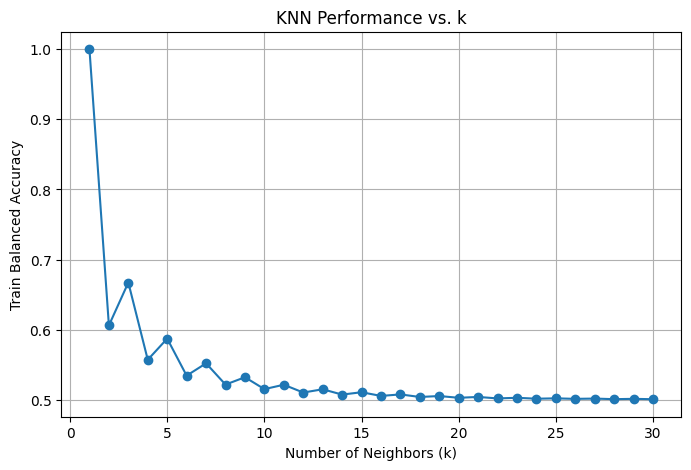

In [22]:
# Plot the K curve

# Range of k values to test
k_values = range(1, 31)   # try k = 1 through 30
results = []

for k in k_values:
    res = run_experiment(
        KNeighborsClassifier(n_neighbors=k),
        X_mend, y_mend_binary_15,
        tree_prep_mend,
        mend_results,
        df_full=df_mend_clean,
        problem_type="classification",
        log_file=mend_log_file,
        cv_log_file=mend_cv_log_file,
        sample_frac=0.2
    )
    results.append(res.get("train_balanced_accuracy"))

# Plot the k curve
plt.figure(figsize=(8,5))
plt.plot(k_values, results, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Train Balanced Accuracy")
plt.title("KNN Performance vs. k")
plt.grid(True)
plt.show()

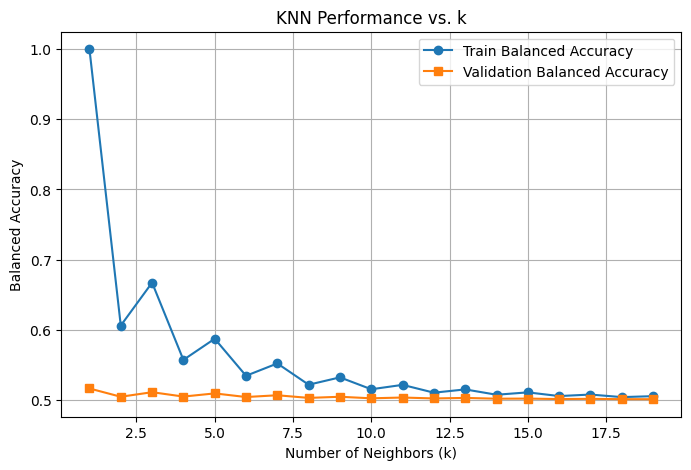

In [32]:
k_values = range(1, 20)
train_scores = []
val_scores = []

for k in k_values:
    res = run_experiment(
        KNeighborsClassifier(n_neighbors=k),
        X_mend, y_mend_binary_15,
        tree_prep_mend,
        mend_results,
        df_full=df_mend_clean,
        problem_type="classification",
        log_file=mend_log_file,
        cv_log_file=mend_cv_log_file,
        sample_frac=0.2
    )
    
    train_scores.append(res["train_balanced_accuracy"])
    val_scores.append(res["test_balanced_accuracy"])

# Plot both curves
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, marker="o", label="Train Balanced Accuracy")
plt.plot(k_values, val_scores, marker="s", label="Validation Balanced Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Balanced Accuracy")
plt.title("KNN Performance vs. k")
plt.legend()
plt.grid(True)
plt.show()

### Boosted Models

#### Gradient Boost

In [33]:
# Gradient Boosting Classifier on Mendeley Data

res = run_experiment(
    GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    X_mend, y_mend_binary_15,   
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.05
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Best params: None
Train AUC: 0.7435451289680918


In [34]:
param_dist = {
    'n_estimators': randint(100, 500),          # Random int between 100-499
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # List to sample from
    'max_depth': [3, 5, 7, 9],                  # List to sample from
    'subsample': uniform(0.7, 0.3),             # Continuous range from 0.7 to 1.0
    'max_features': ['sqrt', 'log2', 1.0]       # List to sample from
}

# Wrap KNN in RandomizedSearchCV
# Note: The rest of your RandomizedSearchCV code remains the same.
knn_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=param_dist, # Use the list of dicts here
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=4,
    verbose=1
)
# ... rest of your code to run the experiment
# Run experiment with randomized search
res = run_experiment(
    knn_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 357, 'subsample': np.float64(0.9165996316800473)}
Train AUC: 0.7678855985955374


#### XG Boost

In [35]:
# XGboost Classifier on Mendeley Data
from xgboost import XGBClassifier

res = run_experiment(
    XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)       

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:00:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: None
Train AUC: 0.7910727790409126


In [45]:
# Define parameter distributions for randomized search
param_dist = {
    "n_estimators": randint(100, 500),          # integers between 100–499
    "learning_rate": uniform(0.01, 0.3),        # continuous range ~0.01–0.31
    "max_depth": randint(3, 10),                # integers between 3–9
    "subsample": uniform(0.6, 0.4),             # continuous range 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),      # continuous range 0.6–1.0
    "gamma": uniform(0, 5),                     # continuous range 0–5
    "min_child_weight": randint(1, 10),         # integers between 1–9
    "scale_pos_weight": uniform(1, 10),          # continuous range 1–10
    "reg_alpha": uniform(1e-3, 1),                 # continuous range 0–1
    "reg_lambda": uniform(1e-3, 1)                 # continuous range 0–
}

# Wrap XGBClassifier in RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(
        tree_method="hist",
        predictor="cpu_predictor",
        eval_metric="logloss",
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=20,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold cross-validation
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    xgb_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\core.py", line 620, in inner_f
    assert self._temporary_data is None
               ^^^^^^^^^^^^^^
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\sklearn.py", line 1445, in fit
    iteration_range=iteration_range,
    ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\sklearn.py", line 708, in get_xgb_params
    feature_weights=feature_weights,
                             ^^^^^^^^
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\sklearn.py", line 692, in get_params
    create_dmatrix: Callable,
                 ^^^^^^^^^^^^^
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\base.py", line 250, in get_params
    value = getattr(self, key)
            ^^^^^^^^^^^^^^^^^^
AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'


#### Light GBM

In [44]:
# Light GBM Classifier on Mendeley Data

from lightgbm import LGBMClassifier

res = run_experiment(
    LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=-1, ),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best params: None
Train AUC: 0.774170770370374


In [46]:
# Define parameter distributions for randomized search
param_dist = {
    "n_estimators": randint(100, 500),          # number of boosting rounds
    "learning_rate": uniform(0.01, 0.3),        # shrinkage rate
    "max_depth": randint(-1, 15),               # -1 means no limit
    "num_leaves": randint(20, 150),             # number of leaves per tree
    "subsample": uniform(0.6, 0.4),             # bagging fraction
    "colsample_bytree": uniform(0.6, 0.4),      # feature fraction
    "min_child_samples": randint(5, 50),        # min data in one leaf
    "reg_alpha": uniform(0, 1),                 # L1 regularization
    "reg_lambda": uniform(0, 1)                 # L2 regularization
}

# Wrap LGBMClassifier in RandomizedSearchCV
lgbm_random = RandomizedSearchCV(
    estimator=LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    ),
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold CV
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    lgbm_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best params: {'colsample_bytree': np.float64(0.7297380084021096), 'learning_rate': np.float64(0.046626386410202), 'max_depth': 7, 'min_child_samples': 43, 'n_estimators': 289, 'num_leaves': 148, 'reg_alpha': np.float64(0.22793516254194168), 'reg_lambda': np.float64(0.4271077886262563), 'subsample': np.float64(0.9272059063689972)}
Train AUC: 0.7992856358073757


#### CatBoost

In [47]:
#CatBoost Classifier on Mendeley Data

res = run_experiment(
    CatBoostClassifier(iterations=200, learning_rate=0.1, random_seed=42, verbose=0),
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Best params: None
Train AUC: 0.7295665370516359


In [48]:

# Define parameter distributions for randomized search
param_dist = {
    "iterations": randint(100, 500),          # boosting rounds
    "learning_rate": uniform(0.01, 0.3),      # shrinkage rate
    "depth": randint(3, 10),                  # tree depth
    "l2_leaf_reg": uniform(1, 10),            # L2 regularization
    "bagging_temperature": uniform(0, 1),     # controls sampling
    "border_count": randint(32, 255)          # number of splits for numerical features
}

# Wrap CatBoost in RandomizedSearchCV
cat_random = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        verbose=0,
        random_seed=42
    ),
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold CV
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    cat_random,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'bagging_temperature': np.float64(0.534089419375442), 'border_count': 93, 'depth': 7, 'iterations': 324, 'l2_leaf_reg': np.float64(2.1986536733368283), 'learning_rate': np.float64(0.11128455142108838)}
Train AUC: 0.770184135392373


In [52]:
# Optuna Hyperparameter Optimization for CatBoost


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    pipe = Pipeline([
        ("preprocessor", tree_prep_mend),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_mend, y_mend_binary_15,
                             cv=cv, scoring="roc_auc", n_jobs=1)
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

# Refit best model on full data and log with your run_experiment
best_model = CatBoostClassifier(**study.best_params, verbose=0, random_seed=42, task_type="GPU")

res = run_experiment(
    best_model,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Train AUC:", res.get("train_auc"))

[I 2025-10-27 09:59:04,850] A new study created in memory with name: no-name-3665419e-6fa3-4cce-9bb5-d9f0c139ad7c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-27 10:00:08,265] Trial 0 finished with value: 0.69043698453826 and parameters: {'iterations': 427, 'learning_rate': 0.011812710852089967, 'depth': 4, 'l2_leaf_reg': 7.723302601974137, 'bagging_temperature': 0.4388701378952925, 'border_count': 43}. Best is trial 0 with value: 0.69043698453826.
[I 2025-10-27 10:01:34,243] Trial 1 finished with value: 0.7296560854558112 and parameters: {'iterations': 444, 'learning_rate': 0.06004589744732589, 'depth': 10, 'l2_leaf_reg': 5.625150954181013, 'bagging_temperature': 0.18521380925129238, 'border_count': 57}. Best is trial 1 with value: 0.7296560854558112.
[I 2025-10-27 10:02:34,248] Trial 2 finished with value: 0.699367123676719 and parameters: {'iterations': 118, 'learning_rate': 0.023267388763674488, 'depth': 9, 'l2_leaf_reg': 1.2108670756695428, 'bagging_temperature': 0.6388789841664139, 'border_count': 128}. Best is trial 1 with value: 0.7296560854558112.
[I 2025-10-27 10:03:50,638] Trial 3 finished with value: 0.7285030878826527

In [53]:
# Optuna Hyperparameter Optimization for CatBoost


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 400, 1200),   # expand upper bound
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15, log=True),
        "depth": trial.suggest_int("depth", 8, 12),                 # focus on deeper trees
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 4, 8),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.3, 1.0),
        "border_count": trial.suggest_int("border_count", 150, 255),
        "task_type": "GPU",
        "random_seed": 42,
        "verbose": 0
    }



    model = CatBoostClassifier(**params)
    pipe = Pipeline([
        ("preprocessor", tree_prep_mend),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_mend, y_mend_binary_15,
                             cv=cv, scoring="roc_auc", n_jobs=1)
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

# Refit best model on full data and log with your run_experiment
best_model = CatBoostClassifier(**study.best_params, verbose=0, random_seed=42, task_type="GPU")

res = run_experiment(
    best_model,
    X_mend, y_mend_binary_15,
    tree_prep_mend,
    mend_results,
    problem_type="classification",
    log_file=mend_log_file,
    cv_log_file=mend_cv_log_file,
    sample_frac=.2
)

print("Train AUC:", res.get("train_auc"))

[I 2025-10-27 15:45:36,481] A new study created in memory with name: no-name-8b16374b-2861-4994-9598-30685fac2a38


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-27 15:48:11,541] Trial 0 finished with value: 0.7300310779923915 and parameters: {'iterations': 1141, 'learning_rate': 0.10855073304876718, 'depth': 10, 'l2_leaf_reg': 5.983760783948414, 'bagging_temperature': 0.3063105020990622, 'border_count': 171}. Best is trial 0 with value: 0.7300310779923915.
[I 2025-10-27 15:49:52,615] Trial 1 finished with value: 0.7311220825330085 and parameters: {'iterations': 755, 'learning_rate': 0.1446624866214222, 'depth': 9, 'l2_leaf_reg': 6.410568458958448, 'bagging_temperature': 0.6277817286093604, 'border_count': 171}. Best is trial 1 with value: 0.7311220825330085.
[I 2025-10-27 15:51:37,460] Trial 2 finished with value: 0.7328994205478124 and parameters: {'iterations': 1069, 'learning_rate': 0.08168251256064904, 'depth': 8, 'l2_leaf_reg': 6.193127233112673, 'bagging_temperature': 0.5992227202243192, 'border_count': 208}. Best is trial 2 with value: 0.7328994205478124.
[I 2025-10-27 15:53:56,051] Trial 3 finished with value: 0.731608879069

### Log Analysis

In [34]:
df_mend_results = pd.read_csv(logs_path / "mend_results_v3.csv")

In [36]:
print(df_mend_results)

              Timestamp                   model  row_count  feature_count  \
0   2025-10-20 14:24:29        LinearRegression    1201631             83   
1   2025-10-20 14:24:45  RandomForestClassifier    1201631             83   
2   2025-10-20 14:25:45  RandomForestClassifier    1201631             83   
3   2025-10-20 14:26:56  RandomForestClassifier      12016             83   
4   2025-10-20 14:59:09        LinearRegression    1201631             83   
..                  ...                     ...        ...            ...   
78  2025-10-26 19:48:32      RandomizedSearchCV     240326             83   
79  2025-10-26 19:48:47      CatBoostClassifier     240326             83   
80  2025-10-26 19:54:53      RandomizedSearchCV     240326             83   
81  2025-10-27 10:36:00      CatBoostClassifier     240326             83   
82  2025-10-27 19:57:06      CatBoostClassifier     240326             83   

    seed  train_r2  train_rmse  train_mae   test_r2  test_rmse  ...  \
0   

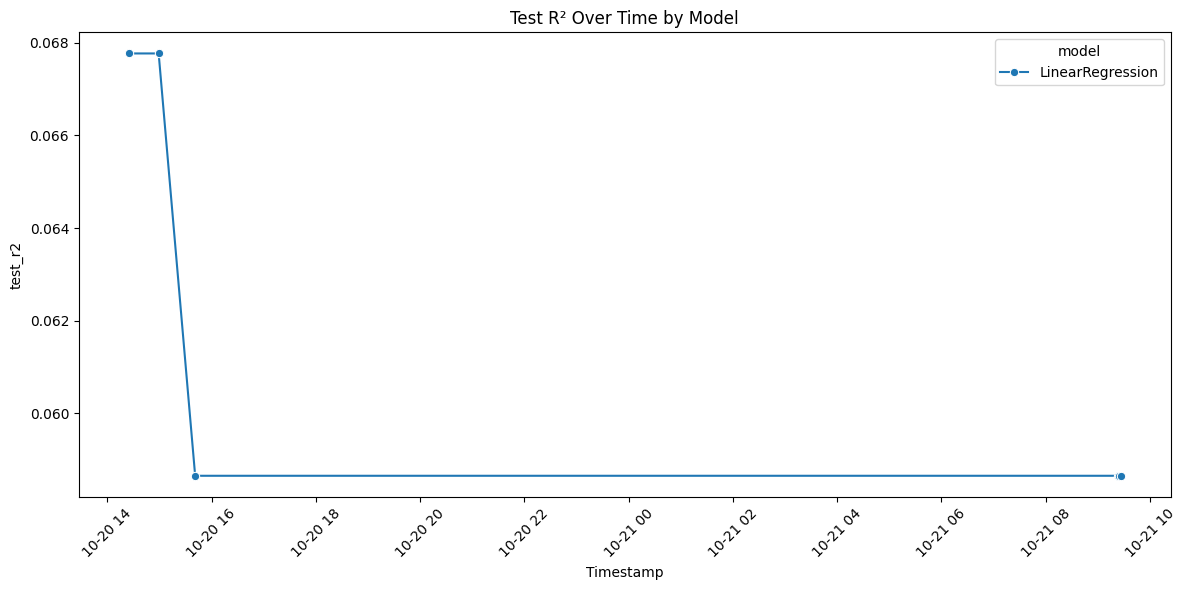

In [ ]:
# Convert Timestamp to datetime
df_mend_results['Timestamp'] = pd.to_datetime(df_mend_results['Timestamp'])

# Filter out rows with valid test_r2
df_valid = df_mend_results.dropna(subset=['test_r2'])

# Line plot of test_r2 over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='Timestamp', y='test_r2', hue='model', marker='o')
plt.title('Test R² Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

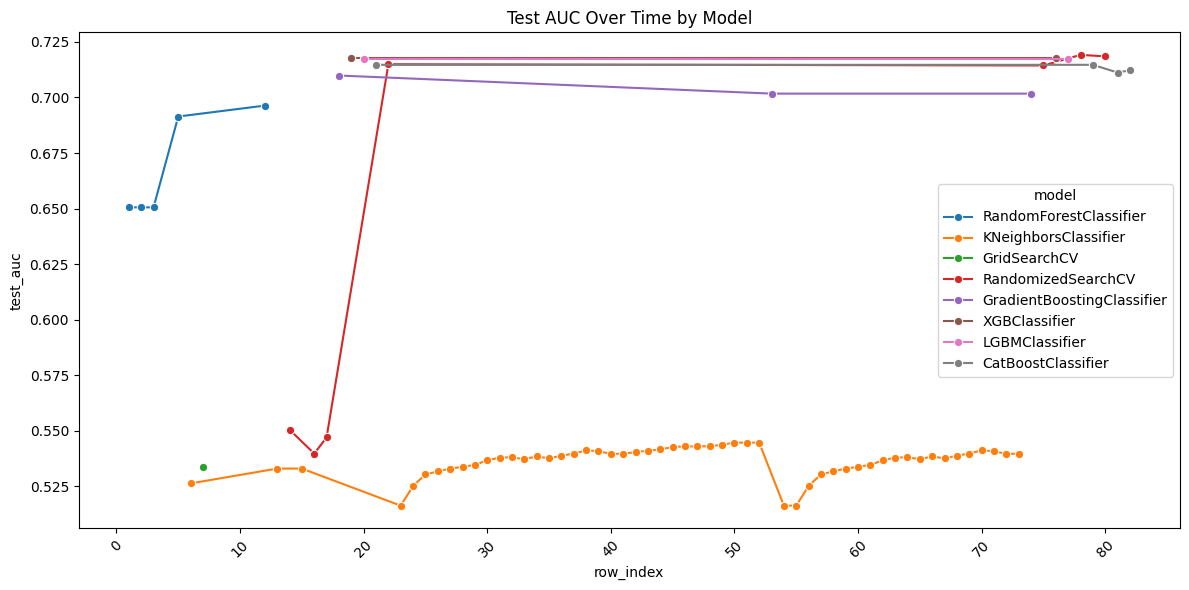

In [41]:
# Convert Timestamp to datetime
df_mend_results['row_index'] = df_mend_results.index

# Filter out rows with valid test_r2
df_valid = df_mend_results.dropna(subset=['test_auc'])

# Line plot of test_auc over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='row_index', y='test_auc', hue='model', marker='o')
plt.title('Test AUC Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

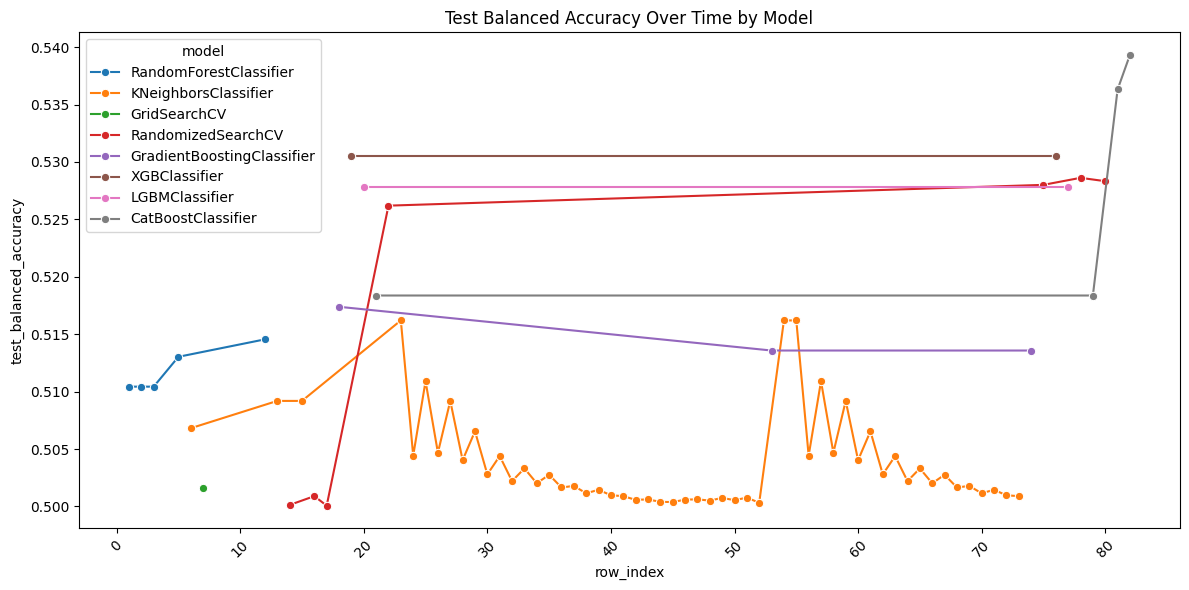

In [42]:
# Convert Timestamp to datetime
df_mend_results['row_index'] = df_mend_results.index

# Filter out rows with valid test_r2
df_valid = df_mend_results.dropna(subset=['test_balanced_accuracy'])

# Line plot of test_auc over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='row_index', y='test_balanced_accuracy', hue='model', marker='o')
plt.title('Test Balanced Accuracy Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## USDOT Modelling

### Linear Regression Models

In [30]:
# Basic Linear Regression on USDOT Data

res = run_experiment(LinearRegression(), X_usdot, y_usdot_numeric, reg_prep_usdot, usdot_results, df_full=df_usdot_clean_filter, problem_type="regression", 
                     log_file=usdot_log_file,
                    cv_log_file=usdot_cv_log_file, sample_frac=.5)

print(res.get("train_r2"))

0.03456755278388779


In [31]:
# Lasso Regression with Hyperparameter Tuning on USDOT Data

# Define base model
lasso = Lasso(max_iter=10000, random_state=42)

# Define parameter grid
param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

# Wrap in GridSearchCV
grid = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Run experiment (GridSearchCV is passed as the "model")
res = run_experiment(
    grid,
    X_usdot, y_usdot_numeric,
    reg_prep_usdot,
    usdot_results,
    df_full=df_usdot_clean,
    problem_type="regression",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file, sample_frac=.5
)

KeyboardInterrupt: 

### Random Forest Models

In [23]:
# Basic Random Forest Classification on USDOT Data

res = run_experiment(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.1
)

print(res.get("train_auc"))

1.0


In [26]:
print(df_usdot)

         year  quarter  month  day_of_month  day_of_week  \
0        2025        1      2             1            6   
1        2025        1      2             1            6   
2        2025        1      2             1            6   
3        2025        1      2             1            6   
4        2025        1      2             1            6   
...       ...      ...    ...           ...          ...   
2906924  2025        2      6            30            1   
2906925  2025        2      6            30            1   
2906926  2025        2      6            30            1   
2906927  2025        2      6            30            1   
2906928  2025        2      6            30            1   

                       fl_date op_unique_carrier  op_carrier_airline_id  \
0         2/1/2025 12:00:00 AM                AA                  19805   
1         2/1/2025 12:00:00 AM                AA                  19805   
2         2/1/2025 12:00:00 AM                AA      

In [15]:
y_usdot_binary_15

0          0
1          1
2          0
3          0
4          0
          ..
2906776    0
2906777    0
2906778    1
2906779    0
2906780    1
Name: dep_delay, Length: 2906781, dtype: int64

In [ ]:
# Hyperparameter Tuning of Random Forest with Randomized Search

# Define hyperparameter distributions
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

# Wrap RandomForest in RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    rf_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("estimator").best_params_)
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


### KNN Models

In [ ]:
#  KNN Classifier on USDOT Data

res = run_experiment(
    KNeighborsClassifier(n_neighbors=5),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    df_full=df_usdot_clean,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=0.2
)

print(res.get("train_balanced_accuracy"))

0.5871399515074643


In [ ]:
# Define hyperparameter distributions
param_dist = {
    "n_neighbors": randint(1, 50),          # number of neighbors
    "weights": ["uniform", "distance"],     # weighting scheme
    "p": [1, 2],                            # 1=Manhattan, 2=Euclidean
    "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "cosine"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": randint(10, 100)           # only relevant for ball_tree/kd_tree
}

# Wrap KNN in RandomizedSearchCV
knn_random = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    knn_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("estimator").best_params_)
print("Train AUC:", res.get("train_auc"))

In [ ]:
# Hyperparameter Tuning KNN Classifier on USDOT Data

param_grid = {"n_neighbors": list(range(2, 11)),
               "weights": ["uniform", "distance"],     # weighting scheme
                "p": [1, 2],                            # 1=Manhattan, 2=Euclidean
                "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "cosine"],
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10, 30, 50, 70, 100]}           # only relevant for ball_tree/kd_tree


grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

res = run_experiment(
    grid,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    df_full=df_usdot_clean,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=0.2
)

print("Best k:", res.get("best_params"))
print("Best CV score:", res.get("best_score"))


Best k: {'n_neighbors': 10}
Best CV score: 0.8083532716113597


### Boosted Models

#### Gradient Boost

In [59]:
# Gradient Boosting Classifier on Mendeley Data

res = run_experiment(
    GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.05
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Best params: None
Train AUC: 0.9869538499779056


In [60]:
param_dist = {
    'n_estimators': randint(100, 500),          # Random int between 100-499
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # List to sample from
    'max_depth': [3, 5, 7, 9],                  # List to sample from
    'subsample': uniform(0.7, 0.3),             # Continuous range from 0.7 to 1.0
    'max_features': ['sqrt', 'log2', 1.0]       # List to sample from
}

# Wrap KNN in RandomizedSearchCV
# Note: The rest of your RandomizedSearchCV code remains the same.
knn_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=param_dist, # Use the list of dicts here
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=4,
    verbose=1
)
# ... rest of your code to run the experiment
# Run experiment with randomized search
res = run_experiment(
    knn_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 357, 'subsample': np.float64(0.9165996316800473)}
Train AUC: 0.9981208281654849


#### XG Boost

In [62]:
# XGboost Classifier on Mendeley Data

res = run_experiment(
    XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)       

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:34:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: None
Train AUC: 0.9955603099161882


In [63]:
# Define parameter distributions for randomized search
param_dist = {
    "n_estimators": randint(100, 500),          # integers between 100–499
    "learning_rate": uniform(0.01, 0.3),        # continuous range ~0.01–0.31
    "max_depth": randint(3, 10),                # integers between 3–9
    "subsample": uniform(0.6, 0.4),             # continuous range 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),      # continuous range 0.6–1.0
    "gamma": uniform(0, 5),                     # continuous range 0–5
    "min_child_weight": randint(1, 10),         # integers between 1–9
    "scale_pos_weight": uniform(1, 10),          # continuous range 1–10
    "reg_alpha": uniform(1e-3, 1),                 # continuous range 0–1
    "reg_lambda": uniform(1e-3, 1)                 # continuous range 0–
}

# Wrap XGBClassifier in RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(
        tree_method="hist",
        predictor="cpu_predictor",
        eval_metric="logloss",
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=20,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold cross-validation
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    xgb_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': np.float64(0.6571467271687763), 'gamma': np.float64(3.254442364744264), 'learning_rate': np.float64(0.02692347370813008), 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 485, 'reg_alpha': np.float64(0.18282496720710062), 'reg_lambda': np.float64(0.18440450985343382), 'scale_pos_weight': np.float64(4.042422429595377), 'subsample': np.float64(0.8099025726528951)}
Train AUC: 0.9914484116489511


#### Light GBM

In [64]:
# Light GBM Classifier on Mendeley Data

from lightgbm import LGBMClassifier

res = run_experiment(
    LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=-1, ),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best params: None
Train AUC: 0.9997962005654139


In [ ]:
# Define parameter distributions for randomized search
param_dist = {
    "n_estimators": randint(100, 500),          # number of boosting rounds
    "learning_rate": uniform(0.01, 0.3),        # shrinkage rate
    "max_depth": randint(-1, 15),               # -1 means no limit
    "num_leaves": randint(20, 150),             # number of leaves per tree
    "subsample": uniform(0.6, 0.4),             # bagging fraction
    "colsample_bytree": uniform(0.6, 0.4),      # feature fraction
    "min_child_samples": randint(5, 50),        # min data in one leaf
    "reg_alpha": uniform(0, 1),                 # L1 regularization
    "reg_lambda": uniform(0, 1)                 # L2 regularization
}

# Wrap LGBMClassifier in RandomizedSearchCV
lgbm_random = RandomizedSearchCV(
    estimator=LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    ),
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold CV
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    lgbm_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best params: {'colsample_bytree': np.float64(0.7297380084021096), 'learning_rate': np.float64(0.046626386410202), 'max_depth': 7, 'min_child_samples': 43, 'n_estimators': 289, 'num_leaves': 148, 'reg_alpha': np.float64(0.22793516254194168), 'reg_lambda': np.float64(0.4271077886262563), 'subsample': np.float64(0.9272059063689972)}
Train AUC: 0.7992856358073757


#### CatBoost

In [65]:
#CatBoost Classifier on Mendeley Data

res = run_experiment(
    CatBoostClassifier(iterations=200, learning_rate=0.1, random_seed=42, verbose=0),
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Best params: None
Train AUC: 0.9628705783636531


In [66]:

# Define parameter distributions for randomized search
param_dist = {
    "iterations": randint(100, 500),          # boosting rounds
    "learning_rate": uniform(0.01, 0.3),      # shrinkage rate
    "depth": randint(3, 10),                  # tree depth
    "l2_leaf_reg": uniform(1, 10),            # L2 regularization
    "bagging_temperature": uniform(0, 1),     # controls sampling
    "border_count": randint(32, 255)          # number of splits for numerical features
}

# Wrap CatBoost in RandomizedSearchCV
cat_random = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        verbose=0,
        random_seed=42
    ),
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    scoring="roc_auc",      # optimize for AUC
    cv=3,                   # 3-fold CV
    random_state=42,
    n_jobs=4,
    verbose=1
)

# Run experiment with randomized search
res = run_experiment(
    cat_random,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Best params:", res.get("best_params"))
print("Train AUC:", res.get("train_auc"))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'bagging_temperature': np.float64(0.9624472949421112), 'border_count': 70, 'depth': 4, 'iterations': 486, 'l2_leaf_reg': np.float64(4.008783098167696), 'learning_rate': np.float64(0.09545214831324028)}
Train AUC: 0.967989815785317


In [ ]:
# Optuna Hyperparameter Optimization for CatBoost


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    pipe = Pipeline([
        ("preprocessor", tree_prep_usdot),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_usdot, y_usdot_binary_15,
                             cv=cv, scoring="roc_auc", n_jobs=1)
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

# Refit best model on full data and log with your run_experiment
best_model = CatBoostClassifier(**study.best_params, verbose=0, random_seed=42, task_type="GPU")

res = run_experiment(
    best_model,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Train AUC:", res.get("train_auc"))

[I 2025-10-27 20:37:17,482] A new study created in memory with name: no-name-d32721d1-c589-44d6-a48c-e92d0a0b3060


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-27 20:37:24,679] Trial 0 finished with value: 0.881758028759911 and parameters: {'iterations': 113, 'learning_rate': 0.028634386585783714, 'depth': 7, 'l2_leaf_reg': 8.82066358329699, 'bagging_temperature': 0.09971160475052943, 'border_count': 251}. Best is trial 0 with value: 0.881758028759911.
[I 2025-10-27 20:37:33,030] Trial 1 finished with value: 0.9111580959860545 and parameters: {'iterations': 292, 'learning_rate': 0.020473997719525024, 'depth': 7, 'l2_leaf_reg': 3.3158529116831903, 'bagging_temperature': 0.9805741082507395, 'border_count': 123}. Best is trial 1 with value: 0.9111580959860545.
[I 2025-10-27 20:37:40,309] Trial 2 finished with value: 0.9249819724238676 and parameters: {'iterations': 136, 'learning_rate': 0.2655757292637147, 'depth': 9, 'l2_leaf_reg': 1.4085964654350152, 'bagging_temperature': 0.44840903507085905, 'border_count': 79}. Best is trial 2 with value: 0.9249819724238676.
[I 2025-10-27 20:37:52,062] Trial 3 finished with value: 0.9060584286156

In [ ]:
# Optuna Hyperparameter Optimization for CatBoost


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 400, 1200),   # expand upper bound
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15, log=True),
        "depth": trial.suggest_int("depth", 8, 12),                 # focus on deeper trees
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 4, 8),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.3, 1.0),
        "border_count": trial.suggest_int("border_count", 150, 255),
        "task_type": "GPU",
        "random_seed": 42,
        "verbose": 0
    }



    model = CatBoostClassifier(**params)
    pipe = Pipeline([
        ("preprocessor", tree_prep_usdot),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_usdot, y_usdot_binary_15,
                             cv=cv, scoring="roc_auc", n_jobs=1)
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

# Refit best model on full data and log with your run_experiment
best_model = CatBoostClassifier(**study.best_params, verbose=0, random_seed=42, task_type="GPU")

res = run_experiment(
    best_model,
    X_usdot, y_usdot_binary_15,
    tree_prep_usdot,
    usdot_results,
    problem_type="classification",
    log_file=usdot_log_file,
    cv_log_file=usdot_cv_log_file,
    sample_frac=.2
)

print("Train AUC:", res.get("train_auc"))

[I 2025-10-27 15:45:36,481] A new study created in memory with name: no-name-8b16374b-2861-4994-9598-30685fac2a38


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-27 15:48:11,541] Trial 0 finished with value: 0.7300310779923915 and parameters: {'iterations': 1141, 'learning_rate': 0.10855073304876718, 'depth': 10, 'l2_leaf_reg': 5.983760783948414, 'bagging_temperature': 0.3063105020990622, 'border_count': 171}. Best is trial 0 with value: 0.7300310779923915.
[I 2025-10-27 15:49:52,615] Trial 1 finished with value: 0.7311220825330085 and parameters: {'iterations': 755, 'learning_rate': 0.1446624866214222, 'depth': 9, 'l2_leaf_reg': 6.410568458958448, 'bagging_temperature': 0.6277817286093604, 'border_count': 171}. Best is trial 1 with value: 0.7311220825330085.
[I 2025-10-27 15:51:37,460] Trial 2 finished with value: 0.7328994205478124 and parameters: {'iterations': 1069, 'learning_rate': 0.08168251256064904, 'depth': 8, 'l2_leaf_reg': 6.193127233112673, 'bagging_temperature': 0.5992227202243192, 'border_count': 208}. Best is trial 2 with value: 0.7328994205478124.
[I 2025-10-27 15:53:56,051] Trial 3 finished with value: 0.731608879069

### Log Analysis

In [43]:
df_usdot_results = pd.read_csv(logs_path / "usdot_results_v3.csv")

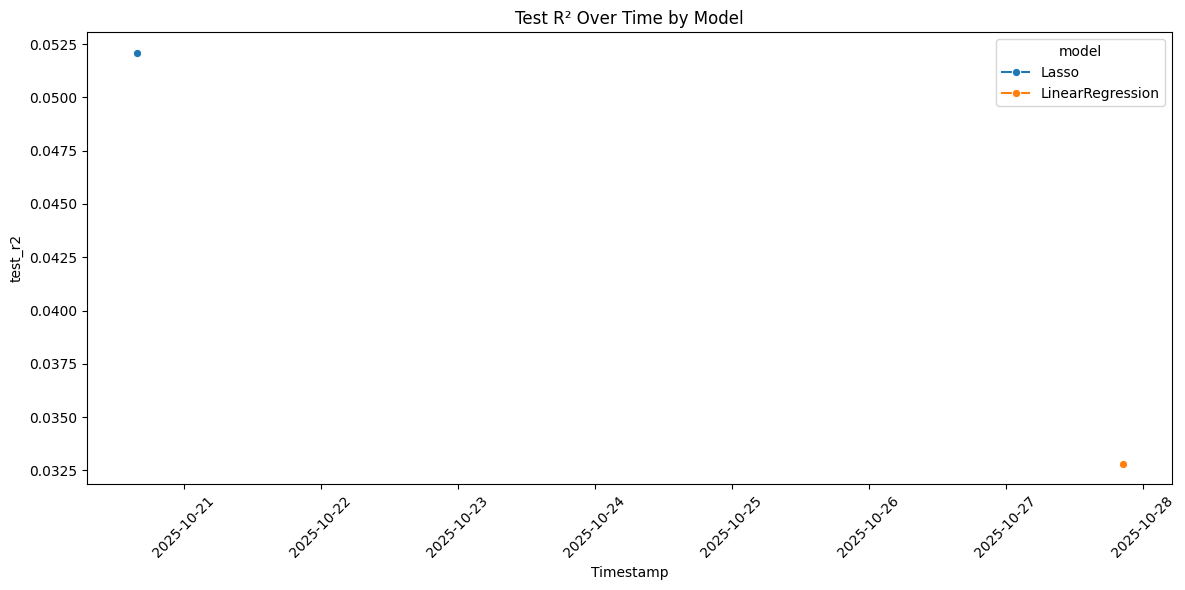

In [44]:
# Convert Timestamp to datetime
df_usdot_results['Timestamp'] = pd.to_datetime(df_usdot_results['Timestamp'])

# Filter out rows with valid test_r2
df_valid = df_usdot_results.dropna(subset=['test_r2'])

# Line plot of test_r2 over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='Timestamp', y='test_r2', hue='model', marker='o')
plt.title('Test R² Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

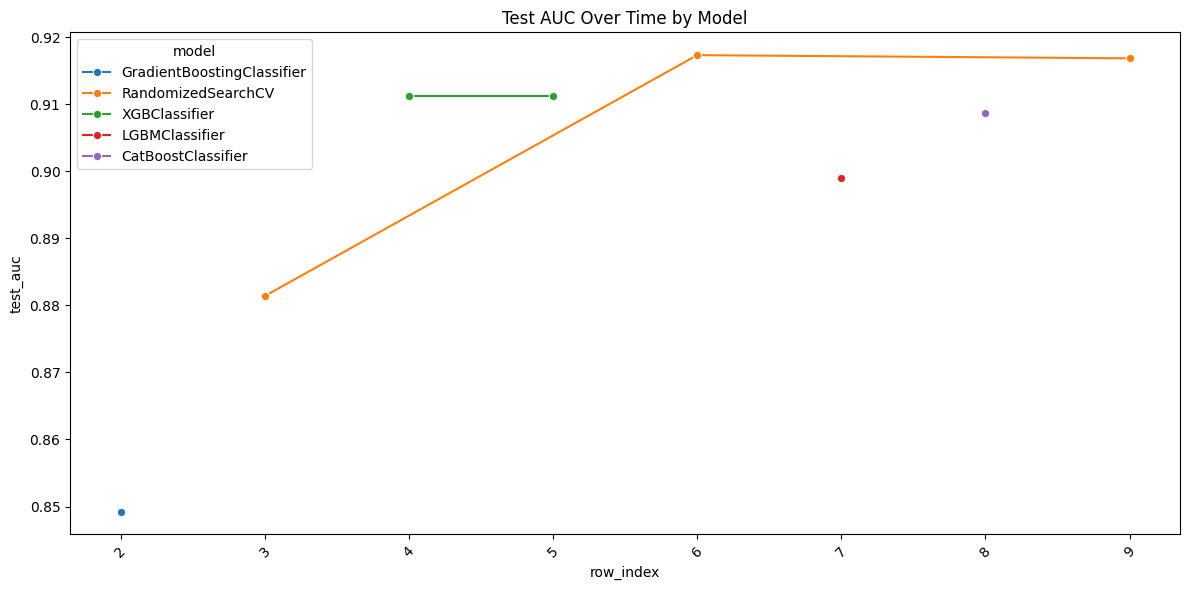

In [45]:
# Convert Timestamp to datetime
df_usdot_results['row_index'] = df_usdot_results.index

# Filter out rows with valid test_r2
df_valid = df_usdot_results.dropna(subset=['test_auc'])

# Line plot of test_auc over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='row_index', y='test_auc', hue='model', marker='o')
plt.title('Test AUC Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

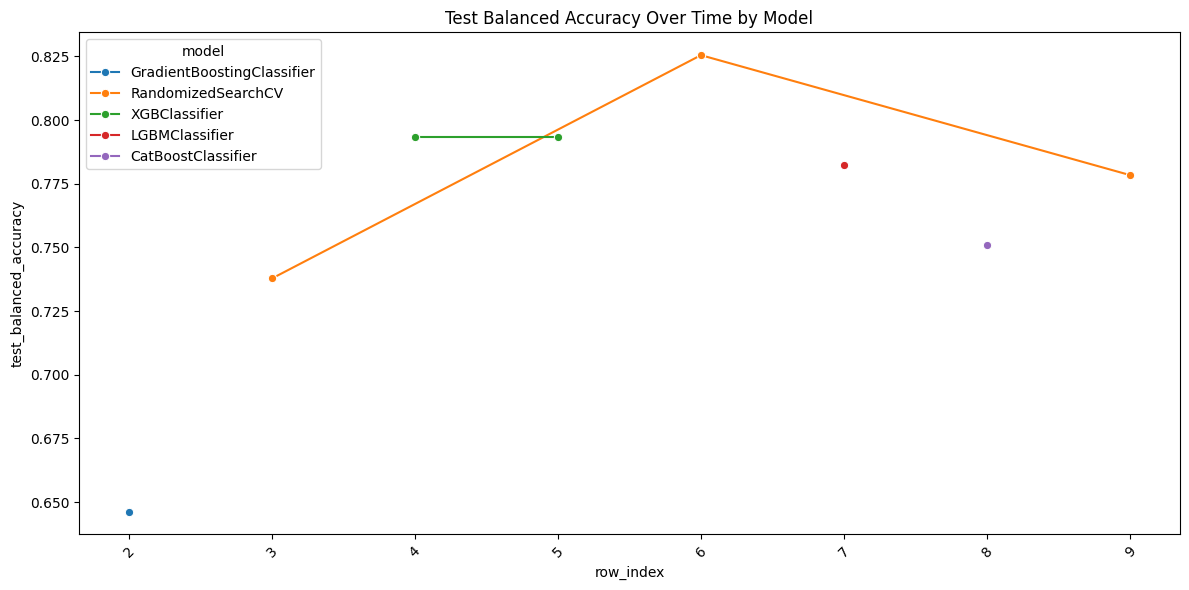

In [46]:
# Convert Timestamp to datetime
df_usdot_results['row_index'] = df_usdot_results.index

# Filter out rows with valid test_r2
df_valid = df_usdot_results.dropna(subset=['test_balanced_accuracy'])

# Line plot of test_auc over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_valid, x='row_index', y='test_balanced_accuracy', hue='model', marker='o')
plt.title('Test Balanced Accuracy Over Time by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Milestone 1

## Mendeley Flight Delay Dataset

## Week 1 – Linear Regression 1
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 1, include concepts such as linear regression with polynomial terms, interaction terms, multicollinearity, variance inflation factor and regression, and categorical and continuous features. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

### Week 1 Helper Functions

In [26]:
def regression_summary(X, y):
    """
    Fits an OLS regression model using statsmodels and prints the summary.
    """
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    return model.summary()

def fit_polynomial_regression(X, y, degree=2):
    """
    Fits a polynomial regression model and returns the fitted model and transformed features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model, poly


def calculate_vif(df, features=None, vif_thresh=10.0):
    """
    Calculate Variance Inflation Factor (VIF) safely:
    - Removes constant and perfectly collinear columns
    - Returns a clean, sorted VIF table
    """
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    X = df[features].copy()

    # 1. Drop constant columns
    constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
    if constant_cols:
        print(f"Dropping constant columns: {constant_cols}")
        X.drop(columns=constant_cols, inplace=True)

    # 2. Drop perfectly collinear columns
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    perfect_corr_cols = [col for col in upper.columns if any(upper[col] == 1.0)]
    if perfect_corr_cols:
        print(f"Dropping perfectly collinear columns: {perfect_corr_cols}")
        X.drop(columns=perfect_corr_cols, inplace=True)

    # 3. Calculate VIF
    X_const = sm.add_constant(X)  # cleaner than assign(const=1)
    vif_data = pd.DataFrame({
        "Feature": X.columns,
        "VIF": [variance_inflation_factor(X_const.values, i+1)  # skip const
                for i in range(len(X.columns))]
    })

    # 4. Sort and format
    vif_data["VIF"] = vif_data["VIF"].round(2)
    vif_data["High_VIF"] = vif_data["VIF"] > vif_thresh
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    return vif_data

### Linear Regression

In [52]:
start_time = time.perf_counter()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mend, y_mend_numeric, test_size=0.2, random_state=42
)

# Build pipeline
linreg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", LinearRegression())
])

# Fit
linreg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = linreg_pipe.predict(X_train)
y_pred_test = linreg_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Get effective feature count after preprocessing
p = linreg_pipe.named_steps["preprocessor"].transform(X_train).shape[1]
n = len(y_test)
adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

train_time = time.perf_counter() - start_time

# Store results
mend_results.append({
    "model": "linear_regression",
    "row_count": len(df_mend_clean),
    "feature_count": X_mend.shape[1],
    "train_r2": train_r2,
    "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "train_mae": mean_absolute_error(y_train, y_pred_train),
    "test_r2": test_r2,
    "test_rmse": test_rmse,
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "adjusted_r2": adjusted_r2,
    "seed": random_state,
    "train_time_sec": train_time
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results_v1.csv')

Train R²: 0.084
Test R²: 0.068
Test RMSE: 33.948


### Polynomial Regression: Second Attempt

Reduced the number of features

In [51]:
start = time.perf_counter()

# Choose 5 features explicitly
selected_features = ["raindummy","snowdummy","windgustdummy","temperature","windspeed","originmetropop", "originmetrogdppercapita"]

# Reduce dataset to 20% of original, but only keep those 5 columns
X_small, _, y_small, _ = train_test_split(
    X_mend[selected_features],  # <--- subset here
    y_mend_numeric,
    train_size=0.2,
    random_state=42
)


# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)


# Define a new preprocessor for just these features
reg_prep_small = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), selected_features)
    ]
)

poly_reg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_small),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

# Fit
poly_reg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = poly_reg_pipe.predict(X_train)
y_pred_test = poly_reg_pipe.predict(X_test)

# Get effective feature count after preprocessing
p = poly_reg_pipe.named_steps["preprocessor"].transform(X_train).shape[1]
n = len(y_test)
adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

train_time = time.perf_counter() - start

# Store results
mend_results.append({
    "model": "polynomial_regression",
    "selected_features": selected_features,
    "degree": 2,
    "row_count": len(X_small),
    "feature_count": X_small.shape[1],
    "train_r2": train_r2,
    "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "train_mae": mean_absolute_error(y_train, y_pred_train),
    "test_r2": test_r2,
    "test_rmse": test_rmse,
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "adjusted_r2": adjusted_r2,
    "seed": random_state,
    "train_time_sec": train_time
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results_v1.csv')

Train R²: 0.018
Test R²: 0.017
Test RMSE: 34.597


### VIF: Variable Inflation Factor

In [ ]:
X_reg_mend_sample = X_reg_mend.sample(n=50000, random_state=42) if len(X_reg_mend) > 10000 else X_reg_mend
vif_table = calculate_vif(X_reg_mend_sample, features=X_reg_mend_sample.columns.tolist(), vif_thresh=10.0)
print(vif_table)

Dropping perfectly collinear columns: ['num__day', 'num__hour']


c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                    feature           VIF  High_VIF
2       low_card__holiday_name_Columbus Day           inf      True
11  low_card__holiday_name_Thanksgiving Day           inf      True
7       low_card__holiday_name_Memorial Day           inf      True
8     low_card__holiday_name_New Year's Day  9.007199e+15      True
5          low_card__holiday_name_Labor Day  1.429714e+13      True
..                                      ...           ...       ...
41                               num__month  1.117527e+00     False
44                       num__scheduledhour  1.069133e+00     False
82                 num__daily_route_flights  1.048853e+00     False
42                          num__dayofmonth  1.034905e+00     False
63                      num__raintracedummy  1.023914e+00     False

[85 rows x 3 columns]


## Week 2 - Linear Regression 2

For Week 2, include concepts such as linear regression with lasso, ridge, and elastic net regression. This homework will be submitted for peer review and feedback in Week 3 in the assignment titled 3.4 Peer Review: Week 2 Jupyter Notebook. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday.

### Lasso Regression

In [50]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", Lasso(alpha=0.1, max_iter=10000, random_state=42))
])

# Fit
lasso_pipe.fit(X_train, y_train)


# Predictions
y_pred_train = lasso_pipe.predict(X_train)
y_pred_test = lasso_pipe.predict(X_test)

# Get effective feature count after preprocessing
p = lasso_pipe.named_steps["preprocessor"].transform(X_train).shape[1]
n = len(y_test)
adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

train_time = time.perf_counter() - start

# Store results
mend_results.append({
    "model": "lasso_regression",
    # "selected_features": selected_features,
    # "degree": 2,
    "row_count": len(X_small),
    "feature_count": X_small.shape[1],
    "train_r2": r2_score(y_train, y_pred_train),
    "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "train_mae": mean_absolute_error(y_train, y_pred_train),
    "test_r2": r2_score(y_test, y_pred_test),
    "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "adjusted_r2": adjusted_r2,
    "seed": random_state,
    "train_time_sec": train_time
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results_v1.csv')

Train R²: 0.109
Test R²: 0.043
Test RMSE: 34.134


### Lasso Grid Search

In [49]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Pipeline: preprocessing + Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", Lasso(max_iter=10000, random_state=42))
])

# Grid of hyperparameters to search
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10]
}

# Grid search with 5-fold CV
grid = GridSearchCV(
    lasso_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Predictions on training set
y_pred_train = grid.predict(X_train)

# Best parameters
print("Best alpha:", grid.best_params_["model__alpha"])

# Get effective feature count after preprocessing
p = grid.best_estimator_.named_steps["preprocessor"].transform(X_train).shape[1]
n = len(y_test)
adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)



# Evaluate on test set
y_pred_test = grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")


train_time = time.perf_counter() - start

# Store results
mend_results.append({
    "model": "lasso_regression_tuned_gridsearch",
    # "selected_features": selected_features,
    # "degree": 2,
    'best_alpha': grid.best_params_["model__alpha"],
    'cv_mean_neg_mse': grid.best_score_,
    "row_count": len(X_small),
    "feature_count": X_small.shape[1],
    "train_r2": r2_score(y_train, y_pred_train),
    "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "train_mae": mean_absolute_error(y_train, y_pred_train),
    "test_r2": r2_score(y_test, y_pred_test),
    "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "adjusted_r2": adjusted_r2,
    "seed": random_state,
    "train_time_sec": train_time
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results_v1.csv')

Best alpha: 0.01
Test R²: 0.043
Test RMSE: 34.126


### Ridge Regression

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Ridge
ridge_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", Ridge(alpha=1.0, max_iter=10000, random_state=42))
])

# Fit
ridge_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = ridge_pipe.predict(X_train)
y_pred_test = ridge_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

#store results
mend_results.append({
    'model': 'Ridge Regression',
    'train_r2': train_r2,
    'test_r2': test_r2, 
    'test_rmse': test_rmse
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Train R²: 0.110
Test R²: 0.043
Test RMSE: 34.129


### Ridge Grid Search

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)
# Pipeline: preprocessing + Ridge
ridge_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", Ridge(max_iter=10000, random_state=42))
])

# Grid of hyperparameters
ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_grid.best_params_["model__alpha"])

y_pred_test = ridge_grid.predict(X_test)
print("Ridge Test R²:", r2_score(y_test, y_pred_test))
print("Ridge Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

#store results
mend_results.append({
    'model': 'Ridge Regression (Tuned)',
    'best_alpha': ridge_grid.best_params_["model__alpha"],
    'train_r2': ridge_grid.best_score_,
    'test_r2': r2_score(y_test, y_pred_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test))
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Best Ridge alpha: 100
Ridge Test R²: 0.04318078243920098
Ridge Test RMSE: 34.12834315489123


### Elastic Net

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Elastic Net
elasticnet_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=42))
])
# Fit
elasticnet_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = elasticnet_pipe.predict(X_train)
y_pred_test = elasticnet_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

#store results
mend_results.append({
    'model': 'Elastic Net Regression',
    'train_r2': train_r2,
    'test_r2': test_r2, 
    'test_rmse': test_rmse
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Train R²: 0.109
Test R²: 0.043
Test RMSE: 34.133


### Elastic Net Grid Search

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)
# Pipeline: preprocessing + ElasticNet
elastic_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", ElasticNet(max_iter=10000, random_state=42))
])

# Grid of hyperparameters
elastic_param_grid = {
    "model__alpha": [0.001, 0.01, 1, 10],
    "model__l1_ratio": [0.2,  0.8]  # balance between L1 and L2
}

elastic_grid = GridSearchCV(
    elastic_pipe,
    elastic_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

elastic_grid.fit(X_train, y_train)

print("Best ElasticNet params:", elastic_grid.best_params_)

y_pred_test = elastic_grid.predict(X_test)
print("ElasticNet Test R²:", r2_score(y_test, y_pred_test))
print("ElasticNet Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

#store results
mend_results.append({
    'model': 'Elastic Net Regression (Tuned)',
    'best_params': elastic_grid.best_params_,
    'train_r2': elastic_grid.best_score_,
    'test_r2': r2_score(y_test, y_pred_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test))
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Best ElasticNet params: {'model__alpha': 0.01, 'model__l1_ratio': 0.8}
ElasticNet Test R²: 0.04327750111011741
ElasticNet Test RMSE: 34.12661820447766


## Week 3 - Linear Regression 3

For Week 3, include concepts such as linear regression with forward and backward selection, PCR, and PLSR. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

### Forward & Backward Selection: Linear Regression

In [ ]:
start = time.perf_counter()
# --- Shrink dataset to 10% ---
print("Sampling 10% of dataset...")
X_sample, _, y_sample, _ = train_test_split(
    X_mend, y_mend_numeric,
    test_size=0.9,
    random_state=42
)

# Preprocess once
print("Preprocessing features...")
X_proc = reg_prep_mend.fit_transform(X_sample, y_sample)
y = y_sample
print(f"Preprocessing complete. Shape: {X_proc.shape}")

# --- Forward Selection (limit to 30 features, step=2) ---
print("Starting Forward Selection...")
forward_rmse = []
k_range_fwd = range(1, min(31, X_proc.shape[1] + 1), 2)

for i, k in enumerate(k_range_fwd, 1):
    print(f"[Forward] Evaluating {k} features ({i}/{len(k_range_fwd)})...")
    sfs = SequentialFeatureSelector(
        estimator=LinearRegression(),
        n_features_to_select=k,
        direction="forward",
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    sfs.fit(X_proc, y)
    mask = sfs.get_support()
    # Evaluate using CV on the reduced feature set
    scores = cross_val_score(
        LinearRegression(),
        X_proc[:, mask],
        y,
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    rmse = np.sqrt(-scores.mean())
    forward_rmse.append(rmse)
    print(f"[Forward] k={k}, RMSE={rmse:.4f}")

best_idx_fwd = np.argmin(forward_rmse)
best_k_fwd = list(k_range_fwd)[best_idx_fwd]
best_rmse_fwd = forward_rmse[best_idx_fwd]
print(f"Forward Selection complete. Best k={best_k_fwd}, RMSE={best_rmse_fwd:.4f}")

mend_results.append({
    'model': 'Forward Selection Linear Regression',
    'num_features': best_k_fwd,
    'best_cv_rmse': best_rmse_fwd,
    'rmse_curve': forward_rmse,
    'k_range': list(k_range_fwd)
})

# --- Backward Selection (step size=3, early stopping) ---
print("Starting Backward Selection...")
backward_rmse = []
k_range_bwd = range(1, X_proc.shape[1] + 1, 3)

tolerance = 1e-3
best_rmse_so_far = np.inf

for i, k in enumerate(k_range_bwd, 1):
    print(f"[Backward] Evaluating {k} features ({i}/{len(k_range_bwd)})...")
    sbs = SequentialFeatureSelector(
        estimator=LinearRegression(),
        n_features_to_select=k,
        direction="backward",
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    sbs.fit(X_proc, y)
    mask = sbs.get_support()

    # Evaluate this subset with CV
    scores = cross_val_score(
        LinearRegression(),
        X_proc[:, mask],
        y,
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    rmse = np.sqrt(-scores.mean())
    backward_rmse.append(rmse)
    print(f"[Backward] k={k}, RMSE={rmse:.4f}")

    # Early stopping if curve flattens
    if best_rmse_so_far - rmse < tolerance:
        print(f"[Backward] Stopping early at {k} features (no significant improvement).")
        break
    best_rmse_so_far = min(best_rmse_so_far, rmse)

best_idx_bwd = np.argmin(backward_rmse)
best_k_bwd = list(k_range_bwd)[:len(backward_rmse)][best_idx_bwd]
best_rmse_bwd = backward_rmse[best_idx_bwd]
print(f"Backward Selection complete. Best k={best_k_bwd}, RMSE={best_rmse_bwd:.4f}")

mend_results.append({
    'model': 'Backward Selection Linear Regression',
    'num_features': best_k_bwd,
    'best_cv_rmse': best_rmse_bwd,
    'rmse_curve': backward_rmse,
    'k_range': list(k_range_bwd)[:len(backward_rmse)]
})

# --- Plot curves ---
print("Plotting results...")
plt.figure(figsize=(8,5))
plt.plot(k_range_fwd, forward_rmse, marker="o", label="Forward Selection")
plt.plot(list(k_range_bwd)[:len(backward_rmse)], backward_rmse, marker="s", label="Backward Selection")
plt.xlabel("Number of Features Selected")
plt.ylabel("CV RMSE")
plt.title("Forward vs Backward Selection (optimized)")
plt.legend()
plt.grid(True)
plt.show()
print("Done.")

Exception ignored in: <function _WeakArrayKeyMap.set.<locals>.on_destroy at 0x00000276BC1389A0>
Traceback (most recent call last):
  File "c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\joblib\_memmapping_reducer.py", line 146, in on_destroy
    def on_destroy(_):

KeyboardInterrupt: 


### PCR
Principal Component Regression

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# PCR pipeline: preprocessing → PCA → Linear Regression
pcr_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),   # your ColumnTransformer
    ("pca", PCA()),                    # dimensionality reduction
    ("model", LinearRegression())
])

# Grid search over number of components
max_components = min(X_train.shape[0], X_train.shape[1])

param_grid = {
    "pca__n_components": list(range(5, max_components+1, 5))
}

pcr_grid = GridSearchCV(
    pcr_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit
pcr_grid.fit(X_train, y_train)

# Best number of components
print("Best n_components:", pcr_grid.best_params_["pca__n_components"])

# Evaluate on test set
y_pred_test = pcr_grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"PCR Test R²: {test_r2:.3f}")
print(f"PCR Test RMSE: {test_rmse:.3f}")

# Store results for comparison
mend_results.append({
    "Model": "PCR",
    "Best Params": pcr_grid.best_params_,
    "Test R²": test_r2,
    "Test RMSE": test_rmse
})


# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Best n_components: 70
PCR Test R²: 0.043
PCR Test RMSE: 34.128


### PLSR
Partial Least Squares Regression

In [ ]:
start = time.perf_counter()
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_mend, y_mend_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_mend_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# PLSR pipeline: preprocessing → PLSRegression
pls_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),   # your ColumnTransformer
    ("model", PLSRegression())
])

# Grid search over number of components
param_grid = {
    "model__n_components": [2, 5, 10, 20, 40]  # tune based on dataset size
}

pls_grid = GridSearchCV(
    pls_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit
pls_grid.fit(X_train, y_train)

# Best number of components
print("Best n_components:", pls_grid.best_params_["model__n_components"])

# Evaluate on test set
y_pred_test = pls_grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"PLSR Test R²: {test_r2:.3f}")
print(f"PLSR Test RMSE: {test_rmse:.3f}")

# Store results for comparison
mend_results.append({
    "Model": "PLSR",
    "Best Params": pls_grid.best_params_,
    "Test R²": test_r2,
    "Test RMSE": test_rmse
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Best n_components: 2
PLSR Test R²: 0.050
PLSR Test RMSE: 34.001


## Week 4 - Logistic Regression and Feature Scaling

For Week 4, include concepts such as logistic regression and feature scaling. This homework should be submitted for peer review in the assignment titled 4.3 Peer Review: Week 4 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

### Log Regression: Basic

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,          # keep 20% of original
    stratify=y_mend_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)


# Build pipeline: preprocessing + logistic regression
logreg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# Fit
logreg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = logreg_pipe.predict(X_train)
y_pred_test = logreg_pipe.predict(X_test)
y_pred_proba = logreg_pipe.predict_proba(X_test)[:, 1]

# Metrics
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Train Balanced Accuracy: {train_bal_acc:.3f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
mend_results.append({
    "Model": "Logistic Regression",
    "Max Iterations": 1000,
    "Solver": "liblinear",
    "Rows Used": X_small.shape[0],
    "Features Used": X_small.shape[1],
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Train Balanced Accuracy": train_bal_acc,
    "Test Balanced Accuracy": test_bal_acc,
    "Test AUC": test_auc
})

# Log results to CSV
log_results_to_csv(mend_results, '../logs/mend_results.csv')

Original size: (1201631, 83)
Reduced size: (240326, 83)
Train Accuracy: 0.822
Test Accuracy: 0.812
Train Balanced Accuracy: 0.564
Test Balanced Accuracy: 0.541
Test AUC: 0.688
Confusion Matrix:
 [[38045  1030]
 [ 8014   977]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89     39075
           1       0.49      0.11      0.18      8991

    accuracy                           0.81     48066
   macro avg       0.66      0.54      0.54     48066
weighted avg       0.76      0.81      0.76     48066



### Log Regression: Forward & Backward Selection: Light

In [ ]:
start = time.perf_counter()
# --- Shrink dataset to 20% with stratification on binary target ---
print("Sampling 20% of dataset with stratification...")
X_sample, _, y_sample, _ = train_test_split(
    X_mend, y_mend_binary_15,
    test_size=0.95,
    random_state=42,
    stratify=y_mend_binary_15
)

# Preprocess once
print("Preprocessing features...")
X_proc = reg_prep_mend.fit_transform(X_sample, y_sample)
y = y_sample
print(f"Preprocessing complete. Shape: {X_proc.shape}")

# Define estimator
logreg = LogisticRegression(max_iter=1000, solver="liblinear")

# --- Forward Selection (limit to 20 features) ---
print("Starting Forward Selection...")
forward_scores = []
k_range_fwd = range(1, min(21, X_proc.shape[1] + 1))

tolerance = 1e-3
best_score_so_far = -np.inf

for i, k in enumerate(k_range_fwd, 1):
    print(f"[Forward] Evaluating {k} features ({i}/{len(k_range_fwd)})...")
    sfs = SequentialFeatureSelector(
        estimator=logreg,
        n_features_to_select=k,
        direction="forward",
        scoring="balanced_accuracy",
        cv=3,
        n_jobs=-1
    )
    sfs.fit(X_proc, y)
    mask = sfs.get_support()
    score = cross_val_score(
        logreg,
        X_proc[:, mask],
        y,
        scoring="balanced_accuracy",
        cv=3
    ).mean()
    forward_scores.append(score)
    print(f"[Forward] k={k}, Balanced Accuracy={score:.4f}")

    # Early stopping if improvement is too small
    if score - best_score_so_far < tolerance:
        print(f"[Forward] Stopping early at {k} features (Δ<{tolerance}).")
        break
    best_score_so_far = max(best_score_so_far, score)

# --- Best forward ---
best_idx_fwd = np.argmax(forward_scores)
best_k_fwd = list(k_range_fwd)[best_idx_fwd]
best_score_fwd = forward_scores[best_idx_fwd]
print(f"Forward Selection complete. Best k={best_k_fwd}, Balanced Accuracy={best_score_fwd:.4f}")

# Refit SFS at best_k_fwd to get feature mask
sfs_best_fwd = SequentialFeatureSelector(
    estimator=logreg,
    n_features_to_select=best_k_fwd,
    direction="forward",
    scoring="balanced_accuracy",
    cv=3,
    n_jobs=-1
)
sfs_best_fwd.fit(X_proc, y)
mask_fwd = sfs_best_fwd.get_support()

# Get feature names
feature_names = reg_prep_mend.get_feature_names_out()
best_features_fwd = feature_names[mask_fwd]
print("Best Forward Features:", best_features_fwd.tolist())

mend_results.append({
    'model': 'Forward Selection Logistic Regression',
    'num_features': best_k_fwd,
    'best_cv_bal_acc': best_score_fwd,
    'score_curve': forward_scores,
    'k_range': list(k_range_fwd),
    'best_features': best_features_fwd.tolist()
})

# --- Backward Selection (step size = 3, early stopping) ---
print("Starting Backward Selection...")
backward_scores = []
n_features = X_proc.shape[1]

tolerance = 1e-3
best_score_so_far = -np.inf

for i, k in enumerate(range(n_features - 1, 0, -1), 1):  # from all features down to 1
    print(f"[Backward] Evaluating {k} features ({i}/{n_features})...")
    sbs = SequentialFeatureSelector(
        estimator=logreg,
        n_features_to_select=k,
        direction="backward",
        scoring="balanced_accuracy",
        cv=2,
        n_jobs=-1
    )
    sbs.fit(X_proc, y)
    mask = sbs.get_support()
    score = cross_val_score(
        logreg,
        X_proc[:, mask],
        y,
        scoring="balanced_accuracy",
        cv=3
    ).mean()
    backward_scores.append(score)
    print(f"[Backward] k={k}, Balanced Accuracy={score:.4f}")

    # Early stopping if curve flattens
    if score - best_score_so_far < tolerance:
        print(f"[Backward] Stopping early at {k} features (Δ<{tolerance}).")
        break
    best_score_so_far = max(best_score_so_far, score)

# Reverse scores so they align with decreasing k
backward_scores = backward_scores[::-1]
k_range_bwd = list(range(n_features, n_features - len(backward_scores), -1))[::-1]

# --- Best backward ---
best_idx_bwd = np.argmax(backward_scores)
best_k_bwd = list(k_range_bwd)[:len(backward_scores)][best_idx_bwd]
best_score_bwd = backward_scores[best_idx_bwd]
print(f"Backward Selection complete. Best k={best_k_bwd}, Balanced Accuracy={best_score_bwd:.4f}")

# Refit SBS at best_k_bwd to get feature mask
sbs_best_bwd = SequentialFeatureSelector(
    estimator=logreg,
    n_features_to_select=best_k_bwd,
    direction="backward",
    scoring="balanced_accuracy",
    cv=3,
    n_jobs=-1
)
sbs_best_bwd.fit(X_proc, y)
mask_bwd = sbs_best_bwd.get_support()

best_features_bwd = feature_names[mask_bwd]
print("Best Backward Features:", best_features_bwd.tolist())

mend_results.append({
    'model': 'Backward Selection Logistic Regression',
    'num_features': best_k_bwd,
    'best_cv_bal_acc': best_score_bwd,
    'score_curve': backward_scores,
    'k_range': list(k_range_bwd)[:len(backward_scores)],
    'best_features': best_features_bwd.tolist()
})

print("Plotting results...")
plt.figure(figsize=(8,5))

# Forward selection curve
plt.plot(
    list(k_range_fwd)[:len(forward_scores)], 
    forward_scores, 
    marker="o", 
    label="Forward Selection"
)

# Backward selection curve
plt.plot(
    list(k_range_bwd)[:len(backward_scores)], 
    backward_scores, 
    marker="s", 
    label="Backward Selection"
)

plt.xlabel("Number of Features Selected")
plt.ylabel("CV Balanced Accuracy")
plt.title("Forward vs Backward Feature Selection (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(best_k_fwd, best_score_fwd, color="blue", s=100, zorder=5, label="Best Forward")
plt.scatter(best_k_bwd, best_score_bwd, color="orange", s=100, zorder=5, label="Best Backward")
print("Done.")

Sampling 20% of dataset with stratification...
Preprocessing features...
Preprocessing complete. Shape: (60081, 100)
Starting Backward Selection...
[Backward] Evaluating 99 features (1/100)...
[Backward] k=99, Balanced Accuracy=0.6017
[Backward] Evaluating 98 features (2/100)...
[Backward] k=98, Balanced Accuracy=0.6017
[Backward] Stopping early at 98 features (Δ<0.001).
Backward Selection complete. Best k=100, Balanced Accuracy=0.6017


ValueError: n_features_to_select must be < n_features.

### Log Regression: Random Search

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 5% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.05,
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# Step 3: Preprocess the data
print("Preprocessing features...")
X_train_proc = reg_prep_mend.fit_transform(X_train, y_train)
X_test_proc = reg_prep_mend.transform(X_test)
print(f"Processed train shape: {X_train_proc.shape}, test shape: {X_test_proc.shape}")

# Step 4: Define base logistic regression
logreg = LogisticRegression(max_iter=5000, solver="saga")

# Parameter distributions for random search
param_distributions = {
    "penalty": ["l1", "l2"],
    "C": loguniform(1e-3, 1e3),
    "solver": ["saga"]
}

# Step 5: Randomized search on all features
print("\nRunning RandomizedSearchCV on all features...")
random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_proc, y_train)

print("Best Params:", random_search.best_params_)

# Step 6: Evaluate on test set
y_pred = random_search.predict(X_test_proc)
y_proba = random_search.predict_proba(X_test_proc)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_proba)
test_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Store results
mend_results.append({
    "Model": "LogReg (Random Search, All Features)",
    "Best Params": random_search.best_params_,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "Test Balanced Accuracy": test_bal_acc
})

Original size: (1201631, 83)
Reduced size: (60081, 83)
Preprocessing features...
Processed train shape: (48064, 100), test shape: (12017, 100)

Running RandomizedSearchCV on all features...
Best Params: {'C': np.float64(695.8780103230359), 'penalty': 'l1', 'solver': 'saga'}
Test Accuracy: 0.796
Test AUC: 0.645
Test Balanced Accuracy: 0.538
Confusion Matrix:
 [[9280  489]
 [1966  282]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      9769
           1       0.37      0.13      0.19      2248

    accuracy                           0.80     12017
   macro avg       0.60      0.54      0.53     12017
weighted avg       0.74      0.80      0.75     12017



### Feature Coefficients

C:\Users\tbran\AppData\Local\Temp\ipykernel_25336\183203467.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


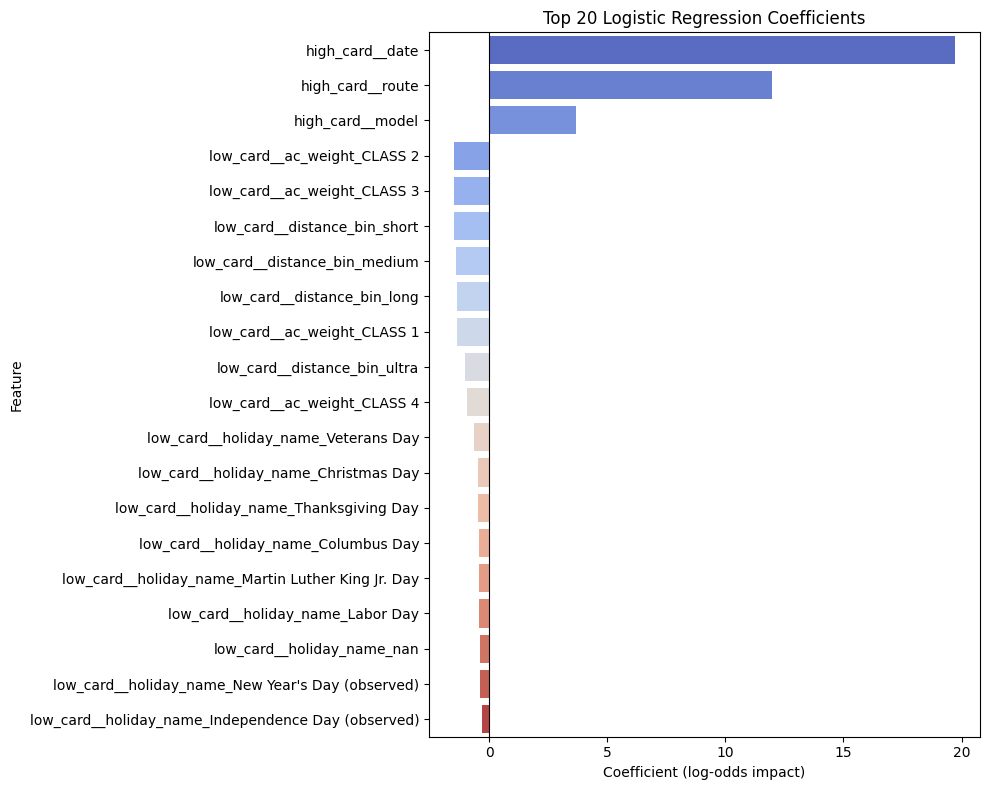

In [17]:
# Extract best model
best_logreg = random_search.best_estimator_

# Get coefficients and feature names
coefs = best_logreg.coef_[0]
feature_names = reg_prep_mend.get_feature_names_out()

# Build DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "AbsCoefficient": abs(coefs)
}).sort_values(by="AbsCoefficient", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(
    data=coef_df.head(20),
    x="Coefficient",
    y="Feature",
    palette="coolwarm",
    dodge=False
)
plt.title("Top 20 Logistic Regression Coefficients")
plt.xlabel("Coefficient (log-odds impact)")
plt.ylabel("Feature")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

### Log Regession: Grid Search

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 5% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.05,
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# Step 3: Preprocess the data
print("Preprocessing features...")
X_train_proc = reg_prep_mend.fit_transform(X_train, y_train)
X_test_proc = reg_prep_mend.transform(X_test)
print(f"Processed train shape: {X_train_proc.shape}, test shape: {X_test_proc.shape}")

# Step 4: Define base logistic regression
logreg = LogisticRegression(max_iter=5000, solver="saga")

# Step 5: Define grid of hyperparameters
param_grid = {
    "C": [0.001, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["saga"]
}

# Step 6: Grid search on all features
print("\nRunning GridSearchCV on all features...")
grid = GridSearchCV(
    logreg,
    param_grid,
    cv=2,
    scoring="roc_auc",
    n_jobs=-1
)
grid.fit(X_train_proc, y_train)

print("Best Params:", grid.best_params_)

# Step 7: Evaluate on test set
y_pred = grid.predict(X_test_proc)
y_proba = grid.predict_proba(X_test_proc)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_proba)
test_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 8: Store results
mend_results.append({
    "Model": "LogReg (Grid Search, All Features)",
    "Best Params": grid.best_params_,
    "Test Accuracy": test_acc,
    "Test AUC": test_auc,
    "Test Balanced Accuracy": test_bal_acc
})

Original size: (1201631, 83)
Reduced size: (60081, 83)
Preprocessing features...
Processed train shape: (48064, 100), test shape: (12017, 100)

Running GridSearchCV on all features...


## Week 5 - Support Vector Machines

For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. 

### SVM Basic

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 5% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.05,
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train_full.shape)
print("Test size:", X_test.shape)

# Step 3: Further split training into train/validation for calibration
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,   # 20% of training set for calibration
    stratify=y_train_full,
    random_state=42
)

# Step 4: Preprocess
X_train_proc = reg_prep_mend.fit_transform(X_train, y_train)
X_val_proc   = reg_prep_mend.transform(X_val)
X_test_proc  = reg_prep_mend.transform(X_test)

# Step 5: Train LinearSVC once
linear_svm = LinearSVC(max_iter=5000, random_state=42)
print("Fitting LinearSVC (no calibration yet)...")
linear_svm.fit(X_train_proc, y_train)

# Step 6: Calibrate using validation set (prefit mode)
calibrated_svm = CalibratedClassifierCV(estimator=linear_svm, cv="prefit")
print("Calibrating probabilities on validation set...")
calibrated_svm.fit(X_val_proc, y_val)

# Step 7: Evaluate on test set
y_pred_test = calibrated_svm.predict(X_test_proc)
y_pred_proba = calibrated_svm.predict_proba(X_test_proc)[:, 1]

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_test))
print("Linear SVM AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Step 8: Store results
mend_results.append({
    "Model": "Linear SVM (Prefit Calibrated)",
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
})

Original size: (1201631, 83)
Reduced size: (60081, 83)
Train size: (48064, 83)
Test size: (12017, 83)
Fitting LinearSVC (no calibration yet)...
Calibrating probabilities on validation set...
Linear SVM Accuracy: 0.8130981110094033
Linear SVM AUC: 0.6261761003013017
Confusion Matrix:
 [[9754   15]
 [2231   17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      9769
           1       0.53      0.01      0.01      2248

    accuracy                           0.81     12017
   macro avg       0.67      0.50      0.46     12017
weighted avg       0.76      0.81      0.73     12017



c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### SVM Random Search

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 10% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.10,           # keep 10% of original
    stratify=y_mend_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20 of reduced set)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,             # 20% of reduced set → 8% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Step 3: Pipeline: preprocessing + SVM
svm_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", SVC(random_state=42))   # no probability=True here (faster)
])

# Step 4: Parameter distributions for randomized search
param_distributions = {
    "model__kernel": ["linear", "rbf"],
    "model__C": loguniform(1e-3, 1e3),
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1]  # only relevant for RBF
}

# Step 5: Randomized search
print("\nRunning RandomizedSearchCV on SVM...")
svm_random = RandomizedSearchCV(
    svm_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)

# Fit
svm_random.fit(X_train, y_train)

# Best parameters
print("Best Params:", svm_random.best_params_)

# Step 6: Evaluate on test set
y_pred_test = svm_random.predict(X_test)

# Use decision_function for ROC/AUC (faster than probability=True)
y_scores = svm_random.decision_function(X_test)

print("Random Search SVM Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Search SVM AUC:", roc_auc_score(y_test, y_scores))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Step 7: Store results
mend_results.append({
    "Model": "SVM (Random Search, All Features)",
    "Best Params": svm_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_scores)
})



Original size: (1201631, 83)
Reduced size: (120163, 83)
Train size: (96130, 83)
Test size: (24033, 83)

Running RandomizedSearchCV on SVM...


KeyboardInterrupt: 

### SVM Grid Search + Kernel Trick: Linear vs. RBF

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 10% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.10,           # actually 10% of original
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20 of reduced set)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Step 3: Pipeline: preprocessing + SVM
# Drop probability=True for speed; use decision_function for ROC/AUC
svm_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", SVC(kernel="rbf", random_state=42))
])

# Step 4: Slimmer hyperparameter grid
param_grid = {
    "model__C": [0.1, 1, 10],          # fewer values
    "model__gamma": ["scale", 0.01, 0.1]  # fewer values
}

# Step 5: Grid search (smaller grid, fewer folds)
print("\nRunning GridSearchCV on SVM (RBF)...")
svm_grid = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=2,                  # reduce folds from 3 to 2
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=False
)

# Fit
svm_grid.fit(X_train, y_train)

# Collect results into DataFrame
cv_results = pd.DataFrame(svm_grid.cv_results_)

# Pivot table for heatmap (mean test AUC)
heatmap_data = cv_results.pivot(
    index="param_model__C",
    columns="param_model__gamma",
    values="mean_test_score"
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title("SVM RBF Kernel: AUC across C and gamma")
plt.ylabel("C (Regularization)")
plt.xlabel("Gamma (Kernel Width)")
plt.show()

# Best params + score
print("Best Params:", svm_grid.best_params_)
print("Best CV AUC:", svm_grid.best_score_)

# Step 6: Evaluate on test set
y_pred_test = svm_grid.predict(X_test)
y_scores = svm_grid.decision_function(X_test)  # faster than predict_proba

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test AUC:", roc_auc_score(y_test, y_scores))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
mend_results.append({
    "Model": "SVM (Grid Search, RBF)",
    "Best Params": svm_grid.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_scores)
})

## Week 6 - Decision Trees and Random Forests 

For Week 6, include concepts such as decision trees and random forests.

### Decision Tree Classifier

Original size: (1201631, 83)
Reduced size: (240326, 83)
Train size: (192260, 83)
Test size: (48066, 83)
Decision Tree Best Params: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 7, 'model__min_samples_split': 10}
Decision Tree Accuracy: 0.6345233637082345
Decision Tree AUC: 0.6584642294957217
Confusion Matrix:
 [[25469 13606]
 [ 3961  5030]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.65      0.74     39075
           1       0.27      0.56      0.36      8991

    accuracy                           0.63     48066
   macro avg       0.57      0.61      0.55     48066
weighted avg       0.75      0.63      0.67     48066



C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\2206877709.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


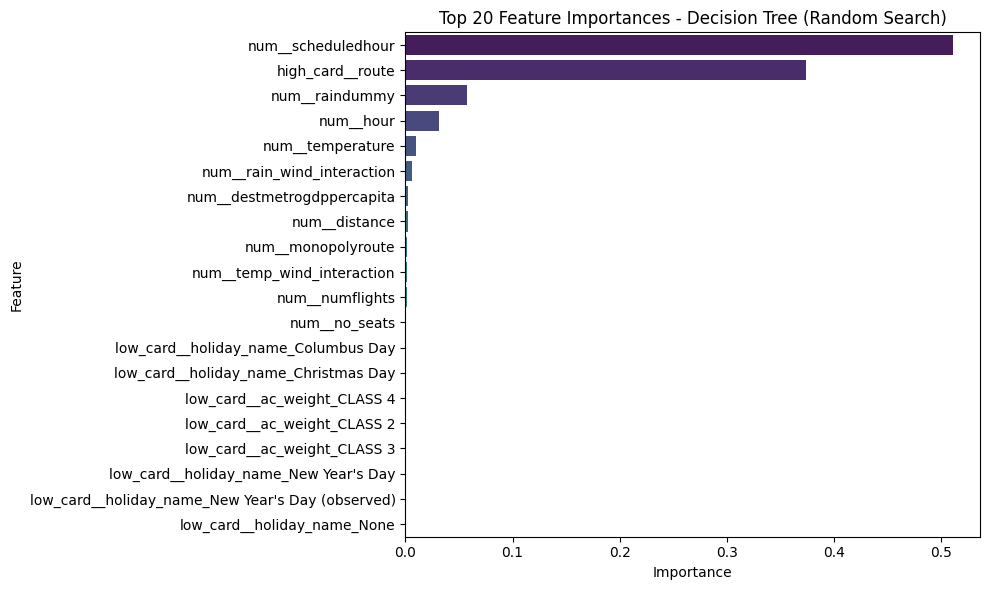

In [ ]:
start = time.perf_counter()

# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --- Pipeline: preprocessing + Decision Tree with class weights ---
dt_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"   # <-- handle class imbalance
    ))
])

# --- Parameter distributions for random search ---
dt_param_dist = {
    "model__max_depth": [None, 3, 5, 10, 20],
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__criterion": ["gini", "entropy", "log_loss"]
}

# --- Randomized search ---
dt_random = RandomizedSearchCV(
    dt_pipe,
    dt_param_dist,
    n_iter=20,              # number of random draws
    cv=3,
    scoring="roc_auc",
    n_jobs=1,
    random_state=42,
    return_train_score=True
)

# --- Fit ---
with parallel_backend("threading"):
    dt_random.fit(X_train, y_train)


# --- Evaluate ---
y_pred_test = dt_random.predict(X_test)
y_pred_proba = dt_random.predict_proba(X_test)[:, 1]

print("Decision Tree Best Params:", dt_random.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_test))
print("Decision Tree AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Store results ---
mend_results.append({
    "Model": "Decision Tree (Random Search, class_weight=balanced)",
    "Best Params": dt_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
})

# ---- Feature Importances ----
best_dt = dt_random.best_estimator_
dt_model = best_dt.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_dt.named_steps["preprocessor"].get_feature_names_out()

# Map importances back to feature names
importances = pd.Series(dt_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Decision Tree (Random Search)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Random Forest Baseline

Random Forest Accuracy: 0.8139641326509383
Random Forest AUC: 0.6867830936075764
Confusion Matrix:
 [[38861   214]
 [ 8728   263]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90     39075
           1       0.55      0.03      0.06      8991

    accuracy                           0.81     48066
   macro avg       0.68      0.51      0.48     48066
weighted avg       0.77      0.81      0.74     48066



C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\1633831745.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


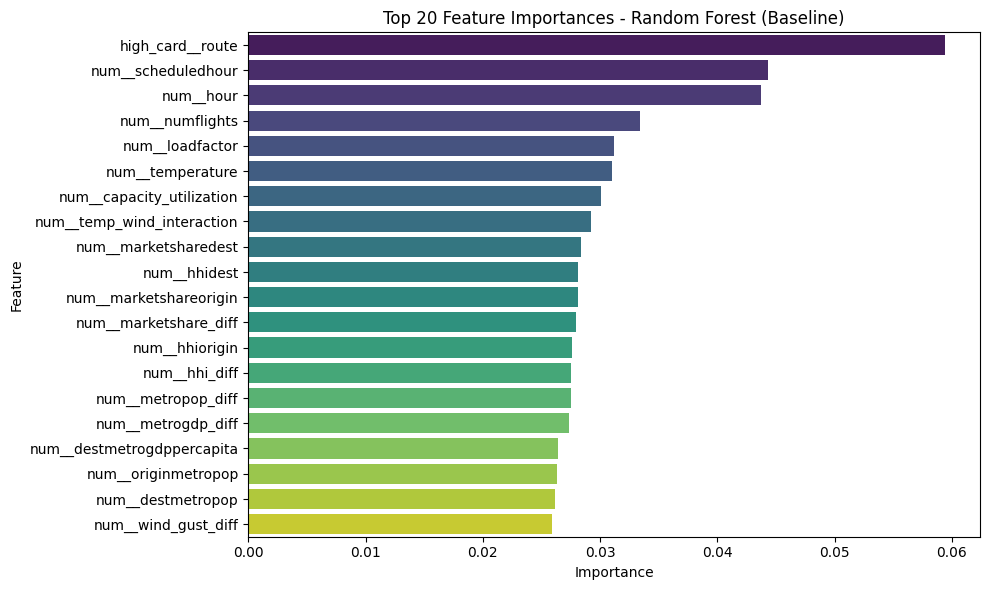

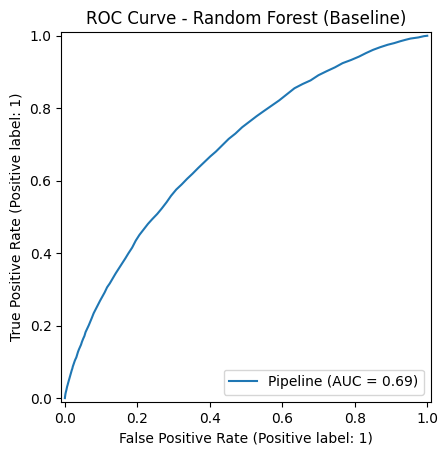

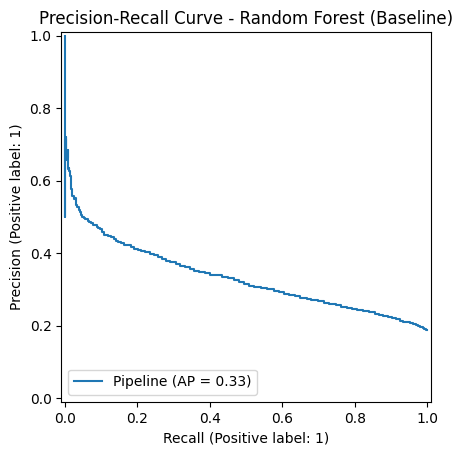

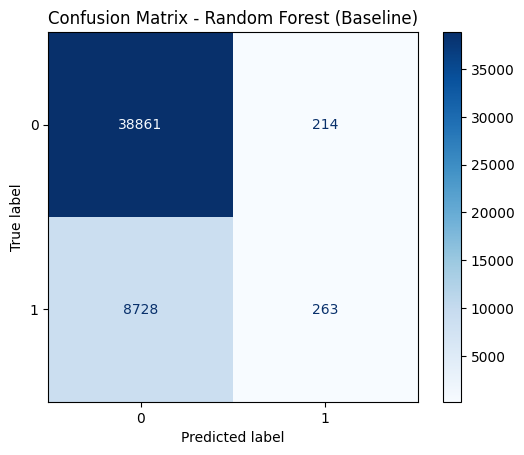

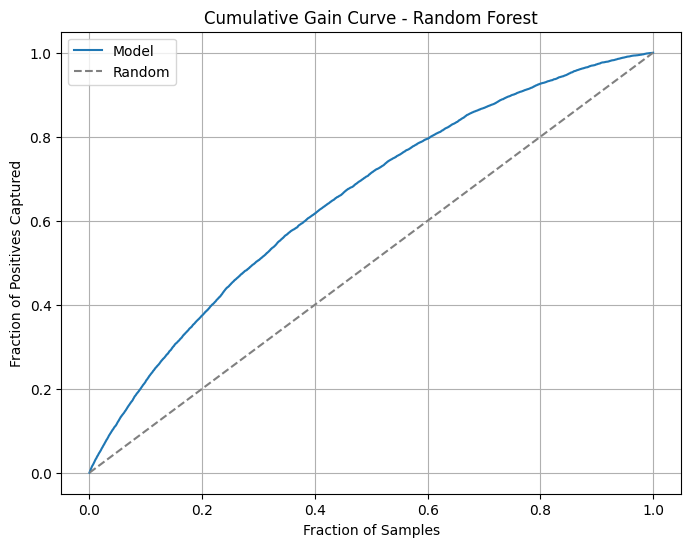

C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\1633831745.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")


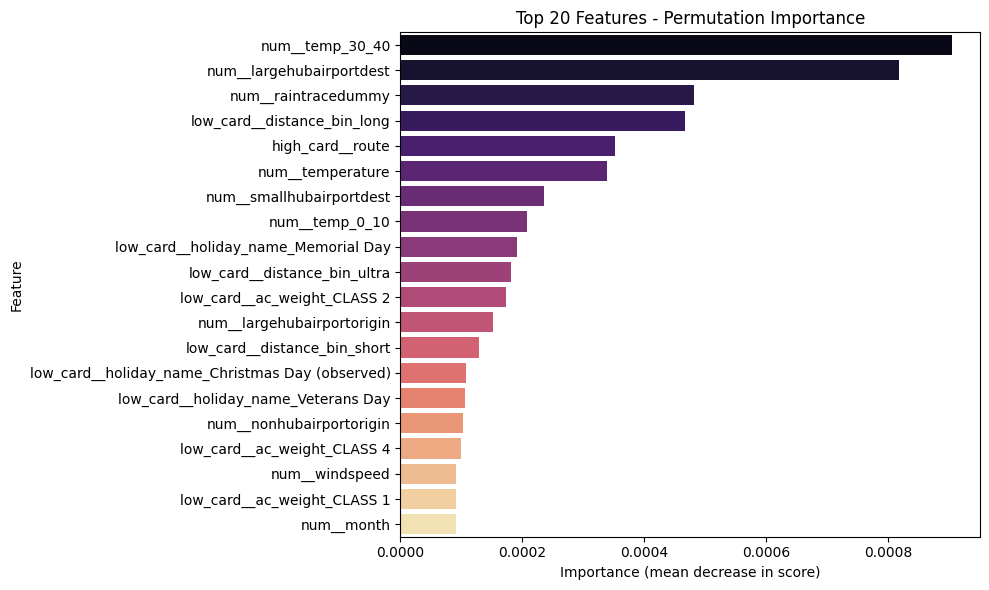

In [ ]:
start = time.perf_counter()
# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,
    stratify=y_mend_binary_15,
    random_state=42
)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# --- Pipeline: preprocessing + Random Forest ---
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,         # let trees expand fully
        random_state=42,
        class_weight="balanced" # handle class imbalance
    ))
])

# --- Fit ---
with parallel_backend("threading"):
    rf_pipe.fit(X_train, y_train)

# --- Evaluate ---
y_pred_test = rf_pipe.predict(X_test)
y_pred_proba = rf_pipe.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Feature Importances ---
rf_model = rf_pipe.named_steps["model"]
feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()

importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Random Forest (Baseline)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test)
plt.title("ROC Curve - Random Forest (Baseline)")
plt.show()


PrecisionRecallDisplay.from_estimator(rf_pipe, X_test, y_test)
plt.title("Precision-Recall Curve - Random Forest (Baseline)")
plt.show()


ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Baseline)")
plt.show()


# Sort by predicted probability
results = pd.DataFrame({"y_true": y_test, "y_score": y_pred_proba})
results = results.sort_values("y_score", ascending=False).reset_index(drop=True)
results["cumulative_positive"] = results["y_true"].cumsum()
results["percent_samples"] = (results.index + 1) / len(results)
results["percent_positives"] = results["cumulative_positive"] / results["y_true"].sum()

plt.figure(figsize=(8,6))
plt.plot(results["percent_samples"], results["percent_positives"], label="Model")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="Random")
plt.xlabel("Fraction of Samples")
plt.ylabel("Fraction of Positives Captured")
plt.title("Cumulative Gain Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

with parallel_backend("threading"):
    perm_importance = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    
# Align feature names with permutation importance output
fitted_feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()
n_importances = len(perm_importance.importances_mean)

# Slice feature names if there's a mismatch
aligned_feature_names = fitted_feature_names[:n_importances]

perm_sorted = pd.Series(
    perm_importance.importances_mean,
    index=aligned_feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")
plt.title("Top 20 Features - Permutation Importance")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Store results ---
mend_results.append({
    "Model": "Random Forest (Baseline)",
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})


### RF w/ Random Search

Original size: (1201631, 83)
Reduced size: (240326, 83)
Train size: (192260, 83)
Test size: (48066, 83)
Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 7, 'model__n_estimators': 341}
Random Forest Accuracy: 0.8059127033662048
Random Forest AUC: 0.6958585599177054
Confusion Matrix:
 [[37254  1821]
 [ 7508  1483]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89     39075
           1       0.45      0.16      0.24      8991

    accuracy                           0.81     48066
   macro avg       0.64      0.56      0.56     48066
weighted avg       0.76      0.81      0.77     48066



C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\3054888992.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


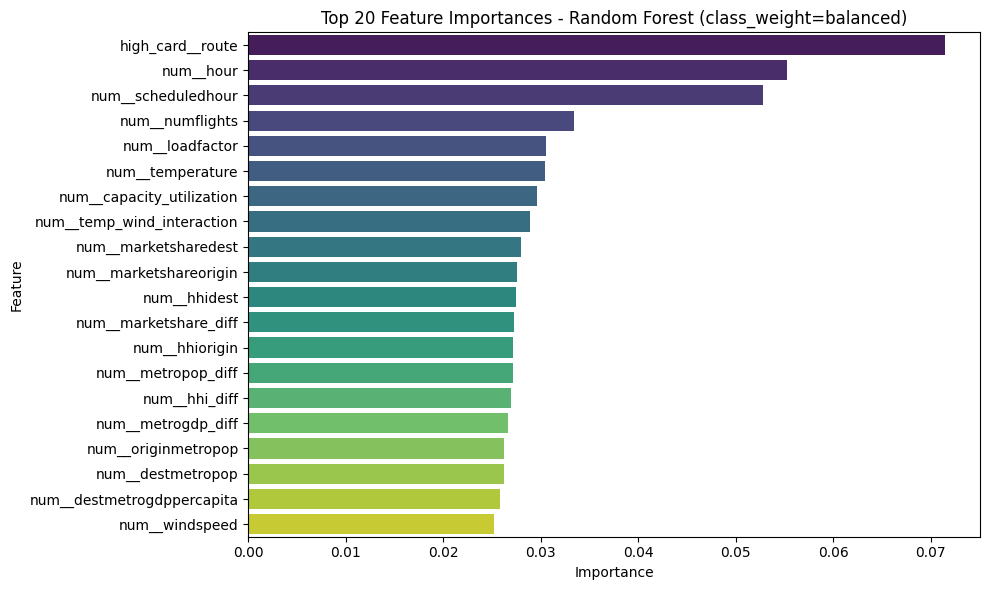

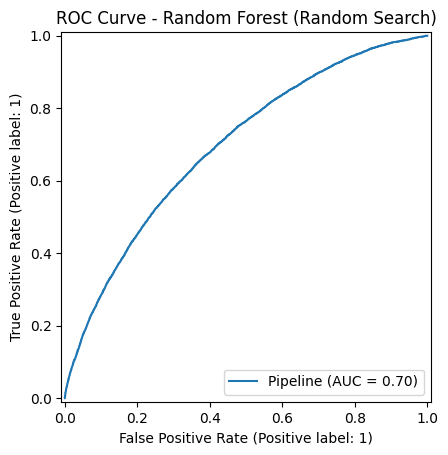

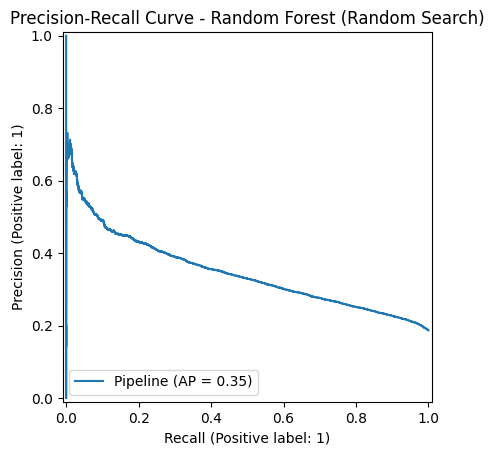

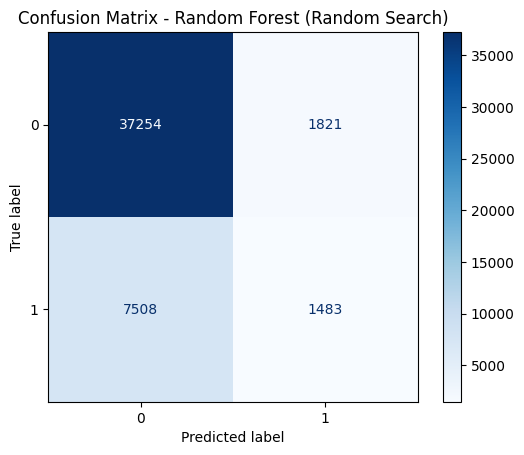

ValueError: Length of values (83) does not match length of index (103)

In [ ]:
start = time.perf_counter()
# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,
    stratify=y_mend_binary_15,
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --- Pipeline: preprocessing + Random Forest with class weights ---
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"   # <-- key change
    ))
])

# --- Parameter distributions for random search ---
rf_param_dist = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5)
}

# --- Randomized search ---
rf_random = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# --- Fit ---
with parallel_backend("threading"):
    rf_random.fit(X_train, y_train)

# --- Evaluate ---
y_pred_test = rf_random.predict(X_test)
y_pred_proba = rf_random.predict_proba(X_test)[:, 1]

print("Random Forest Best Params:", rf_random.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Store results ---
mend_results.append({
    "Model": "Random Forest (Random Search, class_weight=balanced)",
    "Best Params": rf_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

# ---- Feature Importances ----
best_rf = rf_random.best_estimator_
rf_model = best_rf.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

# Map importances back to feature names
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Random Forest (class_weight=balanced)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# --- ROC Curve ---
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Random Forest (Random Search)")
plt.show()

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Precision-Recall Curve - Random Forest (Random Search)")
plt.show()

# --- Confusion Matrix Heatmap ---
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Random Search)")
plt.show()

# --- Permutation Importance (more robust than Gini) ---
with parallel_backend("threading"):
    perm_importance = permutation_importance(
        best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
# Align feature names with the actual number of features used
n_importances = len(perm_importance.importances_mean)
aligned_feature_names = feature_names[:n_importances]

perm_sorted = pd.Series(
    perm_importance.importances_mean,
    index=aligned_feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")
plt.title("Top 20 Features - Permutation Importance")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\3289516647.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")


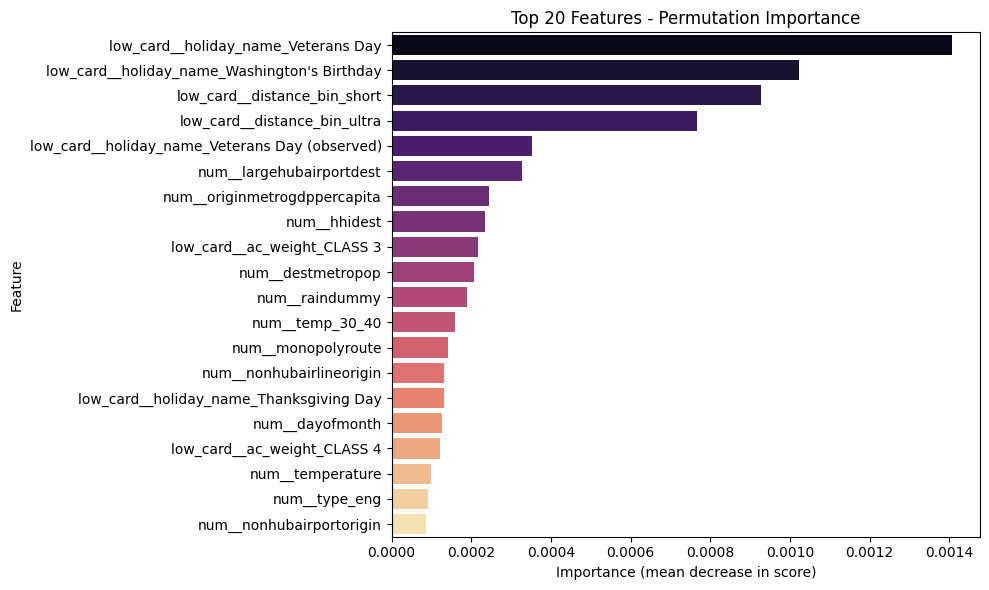

In [107]:
# Align feature names with the actual number of features used
n_importances = len(perm_importance.importances_mean)
aligned_feature_names = feature_names[:n_importances]

perm_sorted = pd.Series(
    perm_importance.importances_mean,
    index=aligned_feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")
plt.title("Top 20 Features - Permutation Importance")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### RF w/ Grid Search

Original size: (1201631, 83)
Reduced size: (240326, 83)
Train size: (192260, 83)
Test size: (48066, 83)
Random Forest Best Params: {'model__max_depth': 25, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Random Forest Accuracy: 0.8002330129405401
Random Forest AUC: 0.6871901317682223
Confusion Matrix:
 [[37040  2035]
 [ 7567  1424]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89     39075
           1       0.41      0.16      0.23      8991

    accuracy                           0.80     48066
   macro avg       0.62      0.55      0.56     48066
weighted avg       0.75      0.80      0.76     48066



C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\678676262.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted.head(20), y=importances_sorted.head(20).index, palette="viridis")


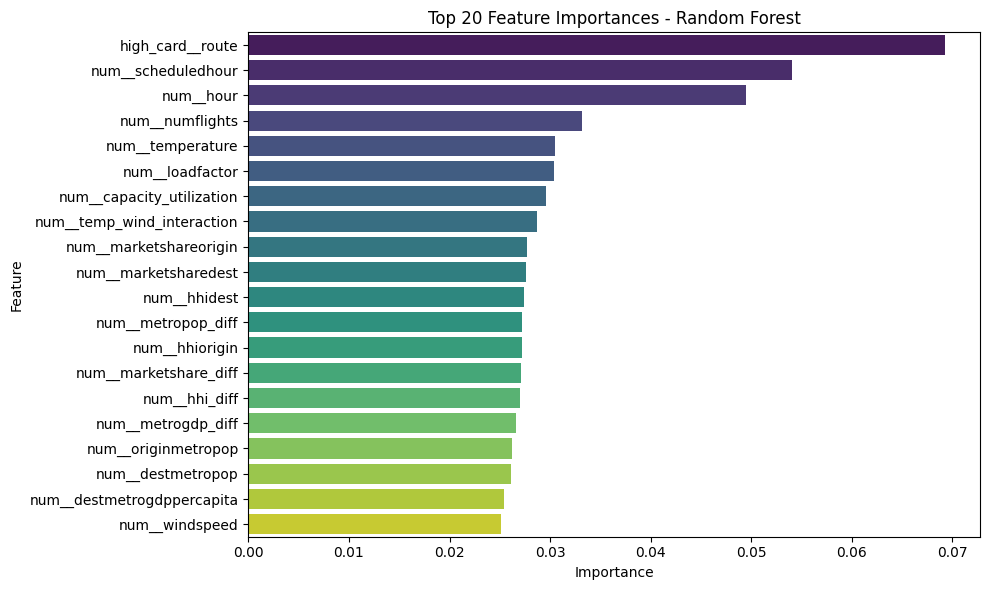

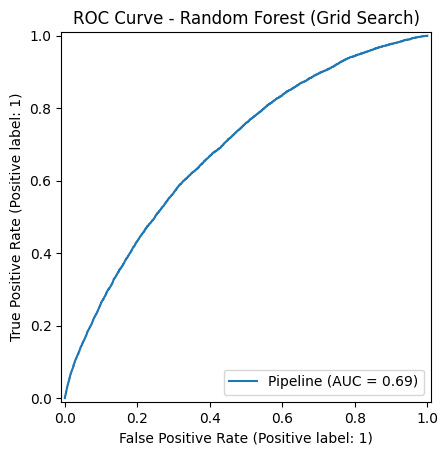

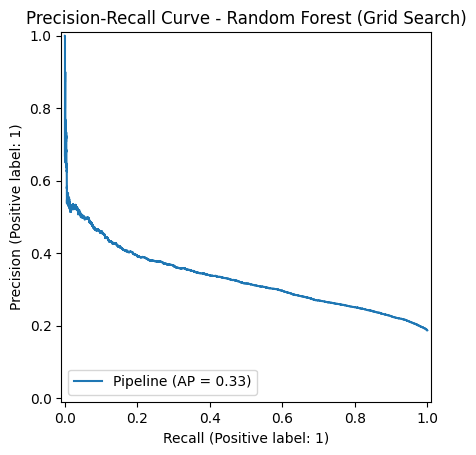

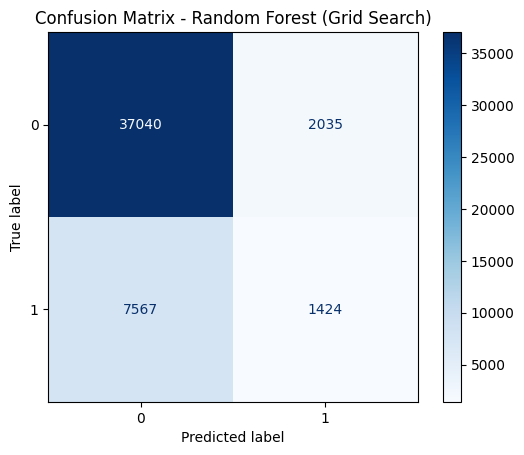

X_test_transformed shape: (48066, 103)
Number of feature names: 103


C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\678676262.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")


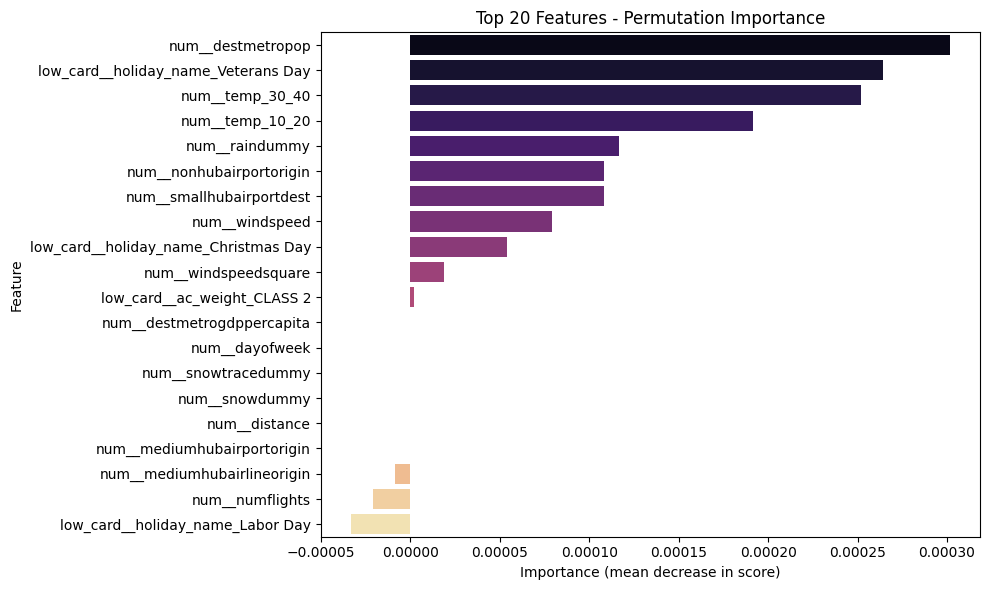

In [ ]:
start = time.perf_counter()
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,          # keep 20% of original
    stratify=y_mend_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_mend.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Pipeline: preprocessing + Random Forest
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# Grid of hyperparameters
rf_param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [5, 10, 25],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

# Grid search
rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=2,
    scoring="roc_auc",
    n_jobs=-1
)

with parallel_backend("threading"):
    rf_grid.fit(X_train, y_train)
    
# Evaluate
y_pred_test = rf_grid.predict(X_test)
y_pred_proba = rf_grid.predict_proba(X_test)[:, 1]

print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
mend_results.append({
    "Model": "Random Forest (Grid Search, class_weight=balanced)",
    "Best Params": rf_grid.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

importances = rf_grid.best_estimator_.named_steps["model"].feature_importances_
feature_names = rf_grid.best_estimator_.named_steps["preprocessor"].get_feature_names_out()
pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Get the best fitted pipeline
best_rf = rf_grid.best_estimator_

# Extract the trained RandomForest model
rf_model = best_rf.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

# Pair feature names with importances
importances = pd.Series(rf_model.feature_importances_, index=feature_names)

# Sort by importance
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(x=importances_sorted.head(20), y=importances_sorted.head(20).index, palette="viridis")
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# --- ROC Curve ---
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Random Forest (Grid Search)")
plt.show()

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Precision-Recall Curve - Random Forest (Grid Search)")
plt.show()

# --- Confusion Matrix Heatmap ---
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Grid Search)")
plt.show()

# Transform X_test with the preprocessor to get the actual feature matrix
X_test_transformed = best_rf.named_steps["preprocessor"].transform(X_test)

# Get the feature names aligned with the transformed matrix
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

print("X_test_transformed shape:", X_test_transformed.shape)
print("Number of feature names:", len(feature_names))

with parallel_backend("threading"):
    perm_importance = permutation_importance(
        best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Align lengths
perm_sorted = pd.Series(
    perm_importance.importances_mean,
    index=feature_names[:len(perm_importance.importances_mean)]
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")
plt.title("Top 20 Features - Permutation Importance")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Week 7 - Milestone 1

### Review Results

In [ ]:
# Convert list of dicts into DataFrame
mend_results_df = pd.DataFrame(mend_results)

# Create a timestamp string like 2025-10-19_09-33-00
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Build the filename with timestamp
filename = f"mend_modeling_results_{timestamp}.csv"

# Save to CSV
mend_results_df.to_csv(filename, index=False)

print(mend_results_df)

                                               Model  Test Accuracy  Test AUC  \
0                           Random Forest (Baseline)       0.813964  0.686783   
1  Random Forest (Random Search, class_weight=bal...       0.805913  0.695859   
2  Random Forest (Grid Search, class_weight=balan...       0.800233  0.687190   

   Balanced Accuracy                                        Best Params  
0           0.511887                                                NaN  
1           0.559170  {'model__max_depth': None, 'model__min_samples...  
2           0.553151  {'model__max_depth': 25, 'model__min_samples_l...  


In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=mend_results_df, x="model", y="test_r2", palette="viridis")
plt.title("Model Comparison (Test R²)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=mend_results_df, x="model", y="test_rmse", palette="magma")
plt.title("Model Comparison (Test RMSE)")
plt.xticks(rotation=45)
plt.show()

## USDOT Carrier On-Time Dataset

## Week 1: Linear Regression 1

### Week 1 Helper Functions

In [42]:
def regression_summary(X, y):
    """
    Fits an OLS regression model using statsmodels and prints the summary.
    """
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    return model.summary()

def fit_polynomial_regression(X, y, degree=2):
    """
    Fits a polynomial regression model and returns the fitted model and transformed features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model, poly


def calculate_vif(df, features=None, vif_thresh=10.0):
    """
    Calculate Variance Inflation Factor (VIF) safely:
    - Removes constant columns
    - Removes perfectly collinear columns
    - Returns sorted VIF table
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric features
        features (list): Optional list of features to check; defaults to all numeric
        vif_thresh (float): Threshold for flagging high VIF
    
    Returns:
        pd.DataFrame: VIF table
    """
    # Select numeric columns if features not provided
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    X = df[features].copy()
    
    # 1. Drop constant columns
    constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
    if constant_cols:
        print(f"Dropping constant columns: {constant_cols}")
        X.drop(columns=constant_cols, inplace=True)
    
    # 2. Drop perfectly collinear columns
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    perfect_corr_cols = [col for col in upper.columns if any(upper[col] == 1.0)]
    if perfect_corr_cols:
        print(f"Dropping perfectly collinear columns: {perfect_corr_cols}")
        X.drop(columns=perfect_corr_cols, inplace=True)
    
    # 3. Calculate VIF
    X_const = X.assign(const=1)
    vif_data = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X_const.values, i) for i in range(len(X.columns))]
    })
    
    # 4. Sort by VIF
    vif_data.sort_values(by="VIF", ascending=False, inplace=True)
    
    # 5. Flag high VIF
    vif_data["High_VIF"] = vif_data["VIF"] > vif_thresh
    
    return vif_data

### Linear Regression

In [75]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_usdot, y_usdot_numeric, test_size=0.2, random_state=42
)

# Build pipeline
linreg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", LinearRegression())
])

# Fit
linreg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = linreg_pipe.predict(X_train)
y_pred_test = linreg_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Store results
usdot_results.append({
    'model': 'Linear Regression',
    'train_r2': train_r2,
    'test_r2': test_r2, 
    'test_rmse': test_rmse
})

Train R²: 0.066
Test R²: 0.056
Test RMSE: 55.334


### Polynomial Regression

Reduced the number of features

In [45]:
# Choose 5 features explicitly
selected_features = ["air_time", "distance", "crs_dep_hour", "is_hub_dest", "is_weekend",
                     "crs_elapsed_time", "taxi_time", "air_time_ratio"]

# Reduce dataset to 20% of original, but only keep those 5 columns
X_small, _, y_small, _ = train_test_split(
    X_usdot[selected_features],  # <-- subset here
    y_usdot_numeric,
    train_size=0.2,
    random_state=42
)


# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)


# Define a new preprocessor for just these features
reg_prep_small = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), selected_features)
    ]
)

poly_reg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_small),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

# Fit
poly_reg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = poly_reg_pipe.predict(X_train)
y_pred_test = poly_reg_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Store results
usdot_results.append({
    'model': 'Polynomial Regression',
    'train_r2': train_r2,
    'test_r2': test_r2,
    'test_rmse': test_rmse
})

Train R²: 0.021
Test R²: 0.021
Test RMSE: 53.167


### VIF: Variable Inflation Factor

In [44]:
X_reg_usdot_sample = X_reg_usdot.sample(n=50000, random_state=42) if len(X_reg_usdot) > 10000 else X_reg_usdot
vif_table = calculate_vif(X_reg_usdot_sample, features=X_reg_usdot_sample.columns.tolist(), vif_thresh=10.0)
print(vif_table)

Dropping constant columns: ['num__year', 'num__flights']
Dropping perfectly collinear columns: ['num__day']


c:\Users\tbran\Python\repos\Semester 3 Repos\capstone\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

## Week 2: Linear Regression 2

### Lasso Regression

In [46]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", Lasso(alpha=0.1, max_iter=10000, random_state=42))
])

# Fit
lasso_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = lasso_pipe.predict(X_train)
y_pred_test = lasso_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

#store results
usdot_results.append({
    'model': 'Lasso Regression',
    'train_r2': train_r2,
    'test_r2': test_r2,
    'test_rmse': test_rmse
})  

Train R²: 0.513
Test R²: 0.543
Test RMSE: 36.326


### Lasso Grid Search

In [47]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Pipeline: preprocessing + Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", Lasso(max_iter=10000, random_state=42))
])

# Grid of hyperparameters to search
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10]
}

# Grid search with 5-fold CV
grid = GridSearchCV(
    lasso_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best parameters
print("Best alpha:", grid.best_params_["model__alpha"])

# Evaluate on test set
y_pred_test = grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Store results
usdot_results.append({
    'model': 'Lasso Regression (Tuned)',
    'best_alpha': grid.best_params_["model__alpha"],
    'train_r2': grid.best_score_,
    'test_r2': test_r2,
    'test_rmse': test_rmse
})

Best alpha: 0.001
Test R²: 0.544
Test RMSE: 36.296


### Ridge Regression

In [48]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Ridge
ridge_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", Ridge(alpha=1.0, max_iter=10000, random_state=42))
])

# Fit
ridge_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = ridge_pipe.predict(X_train)
y_pred_test = ridge_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

#store results
usdot_results.append({
    'model': 'Ridge Regression',
    'train_r2': train_r2,
    'test_r2': test_r2, 
    'test_rmse': test_rmse
})

Train R²: 0.514
Test R²: 0.544
Test RMSE: 36.297


### Ridge Regression Grid Search

In [49]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)
# Pipeline: preprocessing + Ridge
ridge_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", Ridge(max_iter=10000, random_state=42))
])

# Grid of hyperparameters
ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_grid.best_params_["model__alpha"])

y_pred_test = ridge_grid.predict(X_test)
print("Ridge Test R²:", r2_score(y_test, y_pred_test))
print("Ridge Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

#store results
usdot_results.append({
    'model': 'Ridge Regression (Tuned)',
    'best_alpha': ridge_grid.best_params_["model__alpha"],
    'train_r2': ridge_grid.best_score_,
    'test_r2': r2_score(y_test, y_pred_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test))
})

Best Ridge alpha: 10
Ridge Test R²: 0.5437551099225562
Ridge Test RMSE: 36.29647897761978


### Elastic Net

In [50]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# Build pipeline with preprocessing + Elastic Net
elasticnet_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=42))
])
# Fit
elasticnet_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = elasticnet_pipe.predict(X_train)
y_pred_test = elasticnet_pipe.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

#store results
usdot_results.append({
    'model': 'Elastic Net Regression',
    'train_r2': train_r2,
    'test_r2': test_r2, 
    'test_rmse': test_rmse
})

Train R²: 0.512
Test R²: 0.542
Test RMSE: 36.349


### Elastic Net Grid Search

In [51]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)
# Pipeline: preprocessing + ElasticNet
elastic_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", ElasticNet(max_iter=10000, random_state=42))
])

# Grid of hyperparameters
elastic_param_grid = {
    "model__alpha": [0.001, 0.01, 1, 10],
    "model__l1_ratio": [0.2,  0.8]  # balance between L1 and L2
}

elastic_grid = GridSearchCV(
    elastic_pipe,
    elastic_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

elastic_grid.fit(X_train, y_train)

print("Best ElasticNet params:", elastic_grid.best_params_)

y_pred_test = elastic_grid.predict(X_test)
print("ElasticNet Test R²:", r2_score(y_test, y_pred_test))
print("ElasticNet Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

#store results
usdot_results.append({
    'model': 'Elastic Net Regression (Tuned)',
    'best_params': elastic_grid.best_params_,
    'train_r2': elastic_grid.best_score_,
    'test_r2': r2_score(y_test, y_pred_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test))
})

Best ElasticNet params: {'model__alpha': 0.001, 'model__l1_ratio': 0.8}
ElasticNet Test R²: 0.5437775745273824
ElasticNet Test RMSE: 36.29558538285105


## Week 3: Linear Regression 3

### Forward & Backward Selection: Linear Regression

In [ ]:
# --- Shrink dataset to 10% ---
print("Sampling 10% of dataset...")
X_sample, _, y_sample, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    test_size=0.9,
    random_state=42
)

# Preprocess once
print("Preprocessing features...")
X_proc = reg_prep_usdot.fit_transform(X_sample, y_sample)
y = y_sample
print(f"Preprocessing complete. Shape: {X_proc.shape}")

# --- Forward Selection (limit to 30 features, step=2) ---
print("Starting Forward Selection...")
forward_rmse = []
k_range_fwd = range(1, min(31, X_proc.shape[1] + 1), 2)

for i, k in enumerate(k_range_fwd, 1):
    print(f"[Forward] Evaluating {k} features ({i}/{len(k_range_fwd)})...")
    sfs = SequentialFeatureSelector(
        estimator=LinearRegression(),
        n_features_to_select=k,
        direction="forward",
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    sfs.fit(X_proc, y)
    mask = sfs.get_support()
    # Evaluate using CV on the reduced feature set
    scores = cross_val_score(
        LinearRegression(),
        X_proc[:, mask],
        y,
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    rmse = np.sqrt(-scores.mean())
    forward_rmse.append(rmse)
    print(f"[Forward] k={k}, RMSE={rmse:.4f}")

best_idx_fwd = np.argmin(forward_rmse)
best_k_fwd = list(k_range_fwd)[best_idx_fwd]
best_rmse_fwd = forward_rmse[best_idx_fwd]
print(f"Forward Selection complete. Best k={best_k_fwd}, RMSE={best_rmse_fwd:.4f}")

mend_results.append({
    'model': 'Forward Selection Linear Regression',
    'num_features': best_k_fwd,
    'best_cv_rmse': best_rmse_fwd,
    'rmse_curve': forward_rmse,
    'k_range': list(k_range_fwd)
})

# --- Backward Selection (step size=3, early stopping) ---
print("Starting Backward Selection...")
backward_rmse = []
k_range_bwd = range(1, X_proc.shape[1] + 1, 3)

tolerance = 1e-3
best_rmse_so_far = np.inf

for i, k in enumerate(k_range_bwd, 1):
    print(f"[Backward] Evaluating {k} features ({i}/{len(k_range_bwd)})...")
    sbs = SequentialFeatureSelector(
        estimator=LinearRegression(),
        n_features_to_select=k,
        direction="backward",
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    sbs.fit(X_proc, y)
    mask = sbs.get_support()

    # Evaluate this subset with CV
    scores = cross_val_score(
        LinearRegression(),
        X_proc[:, mask],
        y,
        scoring="neg_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    rmse = np.sqrt(-scores.mean())
    backward_rmse.append(rmse)
    print(f"[Backward] k={k}, RMSE={rmse:.4f}")

    # Early stopping if curve flattens
    if best_rmse_so_far - rmse < tolerance:
        print(f"[Backward] Stopping early at {k} features (no significant improvement).")
        break
    best_rmse_so_far = min(best_rmse_so_far, rmse)

best_idx_bwd = np.argmin(backward_rmse)
best_k_bwd = list(k_range_bwd)[:len(backward_rmse)][best_idx_bwd]
best_rmse_bwd = backward_rmse[best_idx_bwd]
print(f"Backward Selection complete. Best k={best_k_bwd}, RMSE={best_rmse_bwd:.4f}")

mend_results.append({
    'model': 'Backward Selection Linear Regression',
    'num_features': best_k_bwd,
    'best_cv_rmse': best_rmse_bwd,
    'rmse_curve': backward_rmse,
    'k_range': list(k_range_bwd)[:len(backward_rmse)]
})

# --- Plot curves ---
print("Plotting results...")
plt.figure(figsize=(8,5))
plt.plot(k_range_fwd, forward_rmse, marker="o", label="Forward Selection")
plt.plot(list(k_range_bwd)[:len(backward_rmse)], backward_rmse, marker="s", label="Backward Selection")
plt.xlabel("Number of Features Selected")
plt.ylabel("CV RMSE")
plt.title("Forward vs Backward Selection (optimized)")
plt.legend()
plt.grid(True)
plt.show()
print("Done.")

### PCR
Principal Component Regression

In [61]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# PCR pipeline: preprocessing → PCA → Linear Regression
pcr_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),   # your ColumnTransformer
    ("pca", PCA()),                    # dimensionality reduction
    ("model", LinearRegression())
])

# Grid search over number of components
max_components = min(X_train.shape[0], X_train.shape[1])

param_grid = {
    "pca__n_components": list(range(5, max_components+1, 5))
}

pcr_grid = GridSearchCV(
    pcr_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit
pcr_grid.fit(X_train, y_train)

# Best number of components
print("Best n_components:", pcr_grid.best_params_["pca__n_components"])

# Evaluate on test set
y_pred_test = pcr_grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"PCR Test R²: {test_r2:.3f}")
print(f"PCR Test RMSE: {test_rmse:.3f}")

# Store results for comparison
usdot_results.append({
    "Model": "PCR",
    "Best Params": pcr_grid.best_params_,
    "Test R²": test_r2,
    "Test RMSE": test_rmse
})


Best n_components: 40
PCR Test R²: 0.544
PCR Test RMSE: 36.298


### PLSR
Partial Least Squares Regression

In [62]:
# Reduce dataset to 20% of original
X_small, _, y_small, _ = train_test_split(
    X_usdot, y_usdot_numeric,
    train_size=0.2,
    stratify=None,   # or stratify=y_usdot_binary_15 if classification
    random_state=42
)

# Train/test split on reduced set
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42
)

# PLSR pipeline: preprocessing → PLSRegression
pls_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),   # your ColumnTransformer
    ("model", PLSRegression())
])

# Grid search over number of components
param_grid = {
    "model__n_components": [2, 5, 10, 20, 40]  # tune based on dataset size
}

pls_grid = GridSearchCV(
    pls_pipe,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit
pls_grid.fit(X_train, y_train)

# Best number of components
print("Best n_components:", pls_grid.best_params_["model__n_components"])

# Evaluate on test set
y_pred_test = pls_grid.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"PLSR Test R²: {test_r2:.3f}")
print(f"PLSR Test RMSE: {test_rmse:.3f}")

# Store results for comparison
usdot_results.append({
    "Model": "PLSR",
    "Best Params": pls_grid.best_params_,
    "Test R²": test_r2,
    "Test RMSE": test_rmse
})

Best n_components: 40
PLSR Test R²: 0.544
PLSR Test RMSE: 36.296


## Week 4: Log Regression and Feature Selection

### Log Regression: Basic

In [63]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.2,          # keep 20% of original
    stratify=y_usdot_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)


# Build pipeline: preprocessing + logistic regression
logreg_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# Fit
logreg_pipe.fit(X_train, y_train)

# Predictions
y_pred_train = logreg_pipe.predict(X_train)
y_pred_test = logreg_pipe.predict(X_test)
y_pred_proba = logreg_pipe.predict_proba(X_test)[:, 1]

# Metrics
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Train Balanced Accuracy: {train_bal_acc:.3f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
usdot_results.append({
    "Model": "Logistic Regression",
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Train Balanced Accuracy": train_bal_acc,
    "Test Balanced Accuracy": test_bal_acc,
    "Test AUC": test_auc
})

Original size: (2906781, 41)
Reduced size: (581356, 41)
Train Accuracy: 1.000
Test Accuracy: 1.000
Train Balanced Accuracy: 1.000
Test Balanced Accuracy: 1.000
Test AUC: 1.000
Confusion Matrix:
 [[91441     0]
 [    0 24831]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     91441
           1       1.00      1.00      1.00     24831

    accuracy                           1.00    116272
   macro avg       1.00      1.00      1.00    116272
weighted avg       1.00      1.00      1.00    116272



### Log Regression: Forward & Backward Selection: Light

In [ ]:
# --- Shrink dataset to 20% with stratification on binary target ---
print("Sampling 20% of dataset with stratification...")
X_sample, _, y_sample, _ = train_test_split(
    X_usdot, y_usdot_binary_15,
    test_size=0.8,
    random_state=42,
    stratify=y_usdot_binary_15
)

# Preprocess once
print("Preprocessing features...")
X_proc = reg_prep_usdot.fit_transform(X_sample, y_sample)
y = y_sample
print(f"Preprocessing complete. Shape: {X_proc.shape}")

# Define estimator
logreg = LogisticRegression(max_iter=1000, solver="liblinear")

# --- Forward Selection (limit to 20 features) ---
print("Starting Forward Selection...")
forward_scores = []
k_range_fwd = range(1, min(21, X_proc.shape[1] + 1))

tolerance = 1e-3
best_score_so_far = -np.inf

for i, k in enumerate(k_range_fwd, 1):
    print(f"[Forward] Evaluating {k} features ({i}/{len(k_range_fwd)})...")
    sfs = SequentialFeatureSelector(
        estimator=logreg,
        n_features_to_select=k,
        direction="forward",
        scoring="balanced_accuracy",
        cv=3,
        n_jobs=-1
    )
    sfs.fit(X_proc, y)
    mask = sfs.get_support()
    score = cross_val_score(
        logreg,
        X_proc[:, mask],
        y,
        scoring="balanced_accuracy",
        cv=3
    ).mean()
    forward_scores.append(score)
    print(f"[Forward] k={k}, Balanced Accuracy={score:.4f}")

    # Early stopping if improvement is too small
    if score - best_score_so_far < tolerance:
        print(f"[Forward] Stopping early at {k} features (Δ<{tolerance}).")
        break
    best_score_so_far = max(best_score_so_far, score)

# --- Best forward ---
best_idx_fwd = np.argmax(forward_scores)
best_k_fwd = list(k_range_fwd)[best_idx_fwd]
best_score_fwd = forward_scores[best_idx_fwd]
print(f"Forward Selection complete. Best k={best_k_fwd}, Balanced Accuracy={best_score_fwd:.4f}")

# Refit SFS at best_k_fwd to get feature mask
sfs_best_fwd = SequentialFeatureSelector(
    estimator=logreg,
    n_features_to_select=best_k_fwd,
    direction="forward",
    scoring="balanced_accuracy",
    cv=3,
    n_jobs=-1
)
sfs_best_fwd.fit(X_proc, y)
mask_fwd = sfs_best_fwd.get_support()

# Get feature names
feature_names = reg_prep_usdot.get_feature_names_out()
best_features_fwd = feature_names[mask_fwd]
print("Best Forward Features:", best_features_fwd.tolist())

usdot_results.append({
    'model': 'Forward Selection Logistic Regression',
    'num_features': best_k_fwd,
    'best_cv_bal_acc': best_score_fwd,
    'score_curve': forward_scores,
    'k_range': list(k_range_fwd),
    'best_features': best_features_fwd.tolist()
})

# --- Backward Selection (step size = 3, early stopping) ---
print("Starting Backward Selection...")
backward_scores = []
n_features = X_proc.shape[1]

tolerance = 1e-3
best_score_so_far = -np.inf

for i, k in enumerate(range(n_features, 0, -1), 1):  # from all features down to 1
    print(f"[Backward] Evaluating {k} features ({i}/{n_features})...")
    sbs = SequentialFeatureSelector(
        estimator=logreg,
        n_features_to_select=k,
        direction="backward",
        scoring="balanced_accuracy",
        cv=3,
        n_jobs=-1
    )
    sbs.fit(X_proc, y)
    mask = sbs.get_support()
    score = cross_val_score(
        logreg,
        X_proc[:, mask],
        y,
        scoring="balanced_accuracy",
        cv=3
    ).mean()
    backward_scores.append(score)
    print(f"[Backward] k={k}, Balanced Accuracy={score:.4f}")

    # Early stopping if curve flattens
    if score - best_score_so_far < tolerance:
        print(f"[Backward] Stopping early at {k} features (Δ<{tolerance}).")
        break
    best_score_so_far = max(best_score_so_far, score)

# Reverse scores so they align with decreasing k
backward_scores = backward_scores[::-1]
k_range_bwd = list(range(n_features, n_features - len(backward_scores), -1))[::-1]

# --- Best backward ---
best_idx_bwd = np.argmax(backward_scores)
best_k_bwd = list(k_range_bwd)[:len(backward_scores)][best_idx_bwd]
best_score_bwd = backward_scores[best_idx_bwd]
print(f"Backward Selection complete. Best k={best_k_bwd}, Balanced Accuracy={best_score_bwd:.4f}")

# Refit SBS at best_k_bwd to get feature mask
sbs_best_bwd = SequentialFeatureSelector(
    estimator=logreg,
    n_features_to_select=best_k_bwd,
    direction="backward",
    scoring="balanced_accuracy",
    cv=3,
    n_jobs=-1
)
sbs_best_bwd.fit(X_proc, y)
mask_bwd = sbs_best_bwd.get_support()

best_features_bwd = feature_names[mask_bwd]
print("Best Backward Features:", best_features_bwd.tolist())

usdot_results.append({
    'model': 'Backward Selection Logistic Regression',
    'num_features': best_k_bwd,
    'best_cv_bal_acc': best_score_bwd,
    'score_curve': backward_scores,
    'k_range': list(k_range_bwd)[:len(backward_scores)],
    'best_features': best_features_bwd.tolist()
})

print("Plotting results...")
plt.figure(figsize=(8,5))

# Forward selection curve
plt.plot(
    list(k_range_fwd)[:len(forward_scores)], 
    forward_scores, 
    marker="o", 
    label="Forward Selection"
)

# Backward selection curve
plt.plot(
    list(k_range_bwd)[:len(backward_scores)], 
    backward_scores, 
    marker="s", 
    label="Backward Selection"
)

plt.xlabel("Number of Features Selected")
plt.ylabel("CV Balanced Accuracy")
plt.title("Forward vs Backward Feature Selection (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(best_k_fwd, best_score_fwd, color="blue", s=100, zorder=5, label="Best Forward")
plt.scatter(best_k_bwd, best_score_bwd, color="orange", s=100, zorder=5, label="Best Backward")
print("Done.")

KeyboardInterrupt: 

### Log Regression: Random Search

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.2,
    stratify=y_usdot_binary_15,
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# --- Use best features from forward and backward selection ---
# (Assume you already have these lists from your earlier step)
# best_features_fwd = [...]
# best_features_bwd = [...]

# Restrict training and test sets to forward-selected features
X_train_fwd = X_train[best_features_fwd]
X_test_fwd = X_test[best_features_fwd]

# Restrict training and test sets to backward-selected features
X_train_bwd = X_train[best_features_bwd]
X_test_bwd = X_test[best_features_bwd]

# Define base logistic regression
logreg = LogisticRegression(max_iter=5000, solver="saga")

# Parameter distributions for random search
param_distributions = {
    "penalty": ["l1", "l2"],
    "C": loguniform(1e-3, 1e3),
    "solver": ["saga"]
}

# --- Forward-selected features ---
print("\nRunning RandomizedSearchCV on Forward-selected features...")
random_search_fwd = RandomizedSearchCV(
    logreg,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=42
)
random_search_fwd.fit(X_train_fwd, y_train)

print("Best Params (Forward):", random_search_fwd.best_params_)

y_pred_fwd = random_search_fwd.predict(X_test_fwd)
y_proba_fwd = random_search_fwd.predict_proba(X_test_fwd)[:, 1]

print("Forward-selected Test Accuracy:", accuracy_score(y_test, y_pred_fwd))
print("Forward-selected Test AUC:", roc_auc_score(y_test, y_proba_fwd))
print("Forward-selected Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_fwd))

usdot_results.append({
    "Model": "LogReg (Forward-selected features)",
    "Best Params": random_search_fwd.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_fwd),
    "Test AUC": roc_auc_score(y_test, y_proba_fwd),
    "Test Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_fwd),
    "Features Used": best_features_fwd
})

# --- Backward-selected features ---
print("\nRunning RandomizedSearchCV on Backward-selected features...")
random_search_bwd = RandomizedSearchCV(
    logreg,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=42
)
random_search_bwd.fit(X_train_bwd, y_train)

print("Best Params (Backward):", random_search_bwd.best_params_)

y_pred_bwd = random_search_bwd.predict(X_test_bwd)
y_proba_bwd = random_search_bwd.predict_proba(X_test_bwd)[:, 1]

print("Backward-selected Test Accuracy:", accuracy_score(y_test, y_pred_bwd))
print("Backward-selected Test AUC:", roc_auc_score(y_test, y_proba_bwd))
print("Backward-selected Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_bwd))

usdot_results.append({
    "Model": "LogReg (Backward-selected features)",
    "Best Params": random_search_bwd.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_bwd),
    "Test AUC": roc_auc_score(y_test, y_proba_bwd),
    "Test Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_bwd),
    "Features Used": best_features_bwd
})

Original size: (1201631, 50)
Reduced size: (240326, 50)
Best Params: {'model__C': np.float64(0.10051981180656774), 'model__penalty': 'l2', 'model__solver': 'saga'}
Test Accuracy: 0.814
Test AUC: 0.678
Test Balanced Accuracy: 0.508
Confusion Matrix:
 [[38931   144]
 [ 8807   184]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     39075
           1       0.56      0.02      0.04      8991

    accuracy                           0.81     48066
   macro avg       0.69      0.51      0.47     48066
weighted avg       0.77      0.81      0.74     48066



### Log Regession: Grid Search

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.2,
    stratify=y_usdot_binary_15,
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# --- Use best features from forward and backward selection ---
# (Assume you already have these lists from your earlier step)
# best_features_fwd = [...]
# best_features_bwd = [...]

# Restrict training and test sets
X_train_fwd = X_train[best_features_fwd]
X_test_fwd = X_test[best_features_fwd]

X_train_bwd = X_train[best_features_bwd]
X_test_bwd = X_test[best_features_bwd]

# Define base logistic regression
logreg = LogisticRegression(max_iter=5000, solver="saga")

# Grid of hyperparameters
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["saga"]
}

# --- Forward-selected features ---
print("\nRunning GridSearchCV on Forward-selected features...")
grid_fwd = GridSearchCV(
    logreg,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)
grid_fwd.fit(X_train_fwd, y_train)

print("Best Params (Forward):", grid_fwd.best_params_)

y_pred_fwd = grid_fwd.predict(X_test_fwd)
y_proba_fwd = grid_fwd.predict_proba(X_test_fwd)[:, 1]

print("Forward-selected Test Accuracy:", accuracy_score(y_test, y_pred_fwd))
print("Forward-selected Test AUC:", roc_auc_score(y_test, y_proba_fwd))

usdot_results.append({
    "Model": "LogReg (Grid Search, Forward-selected features)",
    "Best Params": grid_fwd.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_fwd),
    "Test AUC": roc_auc_score(y_test, y_proba_fwd),
    "Features Used": best_features_fwd
})

# --- Backward-selected features ---
print("\nRunning GridSearchCV on Backward-selected features...")
grid_bwd = GridSearchCV(
    logreg,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)
grid_bwd.fit(X_train_bwd, y_train)

print("Best Params (Backward):", grid_bwd.best_params_)

y_pred_bwd = grid_bwd.predict(X_test_bwd)
y_proba_bwd = grid_bwd.predict_proba(X_test_bwd)[:, 1]

print("Backward-selected Test Accuracy:", accuracy_score(y_test, y_pred_bwd))
print("Backward-selected Test AUC:", roc_auc_score(y_test, y_proba_bwd))

usdot_results.append({
    "Model": "LogReg (Grid Search, Backward-selected features)",
    "Best Params": grid_bwd.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_bwd),
    "Test AUC": roc_auc_score(y_test, y_proba_bwd),
    "Features Used": best_features_bwd
})

Best Params: {'model__C': 10, 'model__penalty': 'l2'}
Test Accuracy: 0.814
Test AUC: 0.675
Confusion Matrix:
 [[194586    788]
 [ 44005    948]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90    195374
           1       0.55      0.02      0.04     44953

    accuracy                           0.81    240327
   macro avg       0.68      0.51      0.47    240327
weighted avg       0.77      0.81      0.74    240327



## Week 5 - Support Vector Machines

For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. 

### SVM Basic

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.05,          # keep 20% of original
    stratify=y_usdot_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Step 3: Pipeline: preprocessing + Linear SVM (with probability calibration)
linear_svm = LinearSVC(max_iter=5000, random_state=42)

# Wrap in calibrated classifier to get predict_proba
calibrated_svm = CalibratedClassifierCV(base_estimator=linear_svm, cv=3)

svm_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", calibrated_svm)
])

# Fit
print("Fitting LinearSVC with calibration...")
svm_pipe.fit(X_train, y_train)

# Predictions
y_pred_test = svm_pipe.predict(X_test)
y_pred_proba = svm_pipe.predict_proba(X_test)[:, 1]

# Metrics
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_test))
print("Linear SVM AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
usdot_results.append({
    "Model": "Linear SVM (Calibrated)",
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
})

Original size: (2906781, 49)
Reduced size: (581356, 49)
Train size: (465084, 49)
Test size: (116272, 49)


: 

: 

### SVM Random Search

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.05,          # keep 20% of original
    stratify=y_usdot_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Pipeline: preprocessing + SVM
svm_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", SVC(probability=True, random_state=42))
])

# Parameter distributions
param_distributions = {
    "model__kernel": ["linear", "rbf"],
    "model__C": loguniform(1e-3, 1e3),   # regularization strength
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1]  # only relevant for RBF
}

# Randomized search
svm_random = RandomizedSearchCV(
    svm_pipe,
    param_distributions=param_distributions,
    n_iter=20,                # number of random samples
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)

# Fit
svm_random.fit(X_train, y_train)

# Best parameters
print("Best Params:", svm_random.best_params_)

# Evaluate on test set
y_pred_test = svm_random.predict(X_test)
y_pred_proba = svm_random.predict_proba(X_test)[:, 1]

print("Random Search SVM Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Search SVM AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

#store results
usdot_results.append({
    "Model": "SVM (Random Search)",
    "Best Params": svm_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
})

### SVM Grid Search + Kernel Trick: Linear vs. RBF

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.05,          # keep 20% of original
    stratify=y_usdot_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Pipeline: preprocessing + SVM
svm_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

# Grid of hyperparameters (RBF only)
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__gamma": [0.001, 0.01, 0.1, 1, "scale"]
}

# Grid search
svm_grid = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit
svm_grid.fit(X_train, y_train)

# Collect results into DataFrame
cv_results = pd.DataFrame(svm_grid.cv_results_)

# Pivot table for heatmap (mean test AUC)
heatmap_data = cv_results.pivot(
    index="param_model__C",
    columns="param_model__gamma",
    values="mean_test_score"
)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title("SVM RBF Kernel: AUC across C and gamma")
plt.ylabel("C (Regularization)")
plt.xlabel("Gamma (Kernel Width)")
plt.show()

# Best params + score
print("Best Params:", svm_grid.best_params_)
print("Best CV AUC:", svm_grid.best_score_)

# Evaluate on test set
y_pred_test = svm_grid.predict(X_test)
y_pred_proba = svm_grid.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

#store results
usdot_results.append({
    "Model": "SVM (Grid Search)",
    "Best Params": svm_grid.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba)
})

## Week 6 - Decision Trees and Random Forests 

For Week 6, include concepts such as decision trees and random forests.

### Decision Tree Classifier

Original size: (2906781, 41)
Reduced size: (581356, 41)
Train size: (465084, 41)
Test size: (116272, 41)
Decision Tree Best Params: {'model__criterion': 'log_loss', 'model__max_depth': 10, 'model__min_samples_leaf': 8, 'model__min_samples_split': 8}
Decision Tree Accuracy: 1.0
Decision Tree AUC: 1.0
Confusion Matrix:
 [[91441     0]
 [    0 24831]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     91441
           1       1.00      1.00      1.00     24831

    accuracy                           1.00    116272
   macro avg       1.00      1.00      1.00    116272
weighted avg       1.00      1.00      1.00    116272



C:\Users\tbran\AppData\Local\Temp\ipykernel_22080\3009188059.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


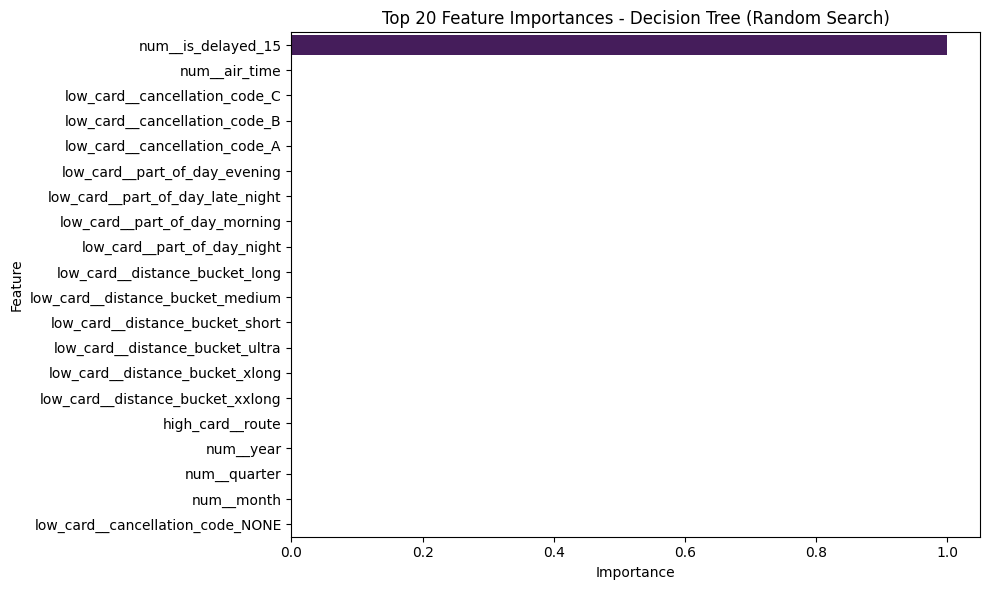

In [ ]:
# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.05,
    stratify=y_usdot_binary_15,
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --- Pipeline: preprocessing + Decision Tree with class weights ---
dt_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"   # <-- handle class imbalance
    ))
])

# --- Parameter distributions for random search ---
dt_param_dist = {
    "model__max_depth": [None, 3, 5, 10, 20],
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__criterion": ["gini", "entropy", "log_loss"]
}

# --- Randomized search ---
dt_random = RandomizedSearchCV(
    dt_pipe,
    dt_param_dist,
    n_iter=20,              # number of random draws
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# --- Fit ---
with parallel_backend("threading"):
    dt_random.fit(X_train, y_train)

# --- Evaluate ---
y_pred_test = dt_random.predict(X_test)
y_pred_proba = dt_random.predict_proba(X_test)[:, 1]

print("Decision Tree Best Params:", dt_random.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_test))
print("Decision Tree AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Store results ---
usdot_results.append({
    "Model": "Decision Tree (Random Search, class_weight=balanced)",
    "Best Params": dt_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

# ---- Feature Importances ----
best_dt = dt_random.best_estimator_
dt_model = best_dt.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_dt.named_steps["preprocessor"].get_feature_names_out()

# Map importances back to feature names
importances = pd.Series(dt_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Decision Tree (Random Search)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Random Forest Baseline

In [ ]:
# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_mend,
    y_mend_binary_15,
    train_size=0.2,
    stratify=y_mend_binary_15,
    random_state=42
)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

# --- Pipeline: preprocessing + Random Forest ---
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_mend),
    ("model", RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,         # let trees expand fully
        random_state=42,
        class_weight="balanced" # handle class imbalance
    ))
])

# --- Fit ---
with parallel_backend("threading"):
    rf_pipe.fit(X_train, y_train)

# --- Evaluate ---
y_pred_test = rf_pipe.predict(X_test)
y_pred_proba = rf_pipe.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Feature Importances ---
rf_model = rf_pipe.named_steps["model"]
feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()

importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Random Forest (Baseline)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Store results ---
usdot_results.append({
    "Model": "Random Forest (Baseline, class_weight=balanced)",
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

### RF w/ Random Search

In [ ]:
# --- Step 1: Reduce dataset to 20% (stratified) ---
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.2,
    stratify=y_usdot_binary_15,
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# --- Step 2: Train/test split (80/20 of reduced set) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --- Pipeline: preprocessing + Random Forest with class weights ---
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"   # <-- key change
    ))
])

# --- Parameter distributions for random search ---
rf_param_dist = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5)
}

# --- Randomized search ---
rf_random = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# --- Fit ---
with parallel_backend("threading"):
    rf_random.fit(X_train, y_train)

# --- Evaluate ---
y_pred_test = rf_random.predict(X_test)
y_pred_proba = rf_random.predict_proba(X_test)[:, 1]

print("Random Forest Best Params:", rf_random.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# --- Store results ---
usdot_results.append({
    "Model": "Random Forest (Random Search, class_weight=balanced)",
    "Best Params": rf_random.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

# ---- Feature Importances ----
best_rf = rf_random.best_estimator_
rf_model = best_rf.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

# Map importances back to feature names
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances_sorted.head(20),
    y=importances_sorted.head(20).index,
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Random Forest (class_weight=balanced)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### RF w/ Grid Search

In [ ]:
# Step 1: Reduce dataset to 20% of original size (stratified)
X_small, _, y_small, _ = train_test_split(
    X_usdot,
    y_usdot_binary_15,
    train_size=0.2,          # keep 20% of original
    stratify=y_usdot_binary_15, # preserve class balance
    random_state=42
)

print("Original size:", X_usdot.shape)
print("Reduced size:", X_small.shape)

# Step 2: Split reduced dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_small,
    y_small,
    test_size=0.2,           # 20% of reduced set → 16% train, 4% test of original
    stratify=y_small,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Pipeline: preprocessing + Random Forest
rf_pipe = Pipeline(steps=[
    ("preprocessor", reg_prep_usdot),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# Grid of hyperparameters
rf_param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [5, 10, 25],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

# Grid search
rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=2,
    scoring="roc_auc",
    n_jobs=-1
)

with parallel_backend("threading"):
    rf_grid.fit(X_train, y_train)

# Evaluate
y_pred_test = rf_grid.predict(X_test)
y_pred_proba = rf_grid.predict_proba(X_test)[:, 1]

print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Store results
usdot_results.append({
    "Model": "Random Forest (Grid Search, class_weight=balanced)",
    "Best Params": rf_grid.best_params_,
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test AUC": roc_auc_score(y_test, y_pred_proba),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test)
})

importances = rf_grid.best_estimator_.named_steps["model"].feature_importances_
feature_names = rf_grid.best_estimator_.named_steps["preprocessor"].get_feature_names_out()
pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Get the best fitted pipeline
best_rf = rf_grid.best_estimator_

# Extract the trained RandomForest model
rf_model = best_rf.named_steps["model"]

# Get feature names from the preprocessor
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

# Pair feature names with importances
importances = pd.Series(rf_model.feature_importances_, index=feature_names)

# Sort by importance
importances_sorted = importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(x=importances_sorted.head(20), y=importances_sorted.head(20).index, palette="viridis")
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- ROC Curve ---
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Random Forest (Grid Search)")
plt.show()

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Precision-Recall Curve - Random Forest (Grid Search)")
plt.show()

# --- Confusion Matrix Heatmap ---
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Grid Search)")
plt.show()

# Transform X_test with the preprocessor to get the actual feature matrix
X_test_transformed = best_rf.named_steps["preprocessor"].transform(X_test)

# Get the feature names aligned with the transformed matrix
feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

print("X_test_transformed shape:", X_test_transformed.shape)
print("Number of feature names:", len(feature_names))
with parallel_backend("threading"):
    perm_importance = permutation_importance(
        best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )

# Align lengths
perm_sorted = pd.Series(
    perm_importance.importances_mean,
    index=feature_names[:len(perm_importance.importances_mean)]
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_sorted.head(20), y=perm_sorted.head(20).index, palette="magma")
plt.title("Top 20 Features - Permutation Importance")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



## Week 7 - Milestone 1